### IS4242 Group 8 Project

### Exploratory Data Analysis

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from spacy.lang.de.stop_words import STOP_WORDS

from scipy import spatial
import gensim.downloader as api
import time
import copy
import pickle

%matplotlib inline
plt.style.use('ggplot')
sns.set_theme()

In [3]:
# Constants

TARGET_VARS = ["hate", "privacy", "sexual",
               "impersonation", "illegal", "advertisement", "ai"]
RANDOM_STATE = 420

### Exploring the processed dataset

In [4]:
df = pd.read_csv('data/df_combined_processed_no_reddit_title_no_stem_no_lemma_2023-04-02.csv')
df

body  hate  privacy  \
0      kalleron design refuse collection recycling si...     0        0   
1      hotmeringue2880 hi economics graduate years ex...     0        0   
2      milenakowalska hey year finish bachelor degree...     0        0   
3      rstonerphd studying makes employees want leave...     0        0   
4      temporarysection50 hi accepted job offer earli...     0        0   
...                                                  ...   ...      ...   
41198  yous muthafin lie 8220lifeasking 20pearls core...     1        0   
41199  youve gone broke wrong heart baby drove rednec...     0        0   
41200  young buck wanna eat dat nigguh like aint fuck...     1        0   
41201                  youu got wild bitches tellin lies     1        0   
41202  ruffled ntac eileen dahlia beautiful color com...     0        0   

       sexual  impersonation  illegal  advertisement  ai  
0           0              0        0              0   0  
1           0              0        0              0   0  
2           0              0        0              0   0  
3           0              0        0              1   0  
4           0              0        0              0   0  
...       ...            ...      ...            ...  ..  
41198       0              0        0              0   0  
41199       0              0        0              0   0  
41200       0              0        0              0   0  
41201       0              0        0              0   0  
41202       0              0        0              0   0  

[41203 rows x 8 columns]

### Target Class Exploration

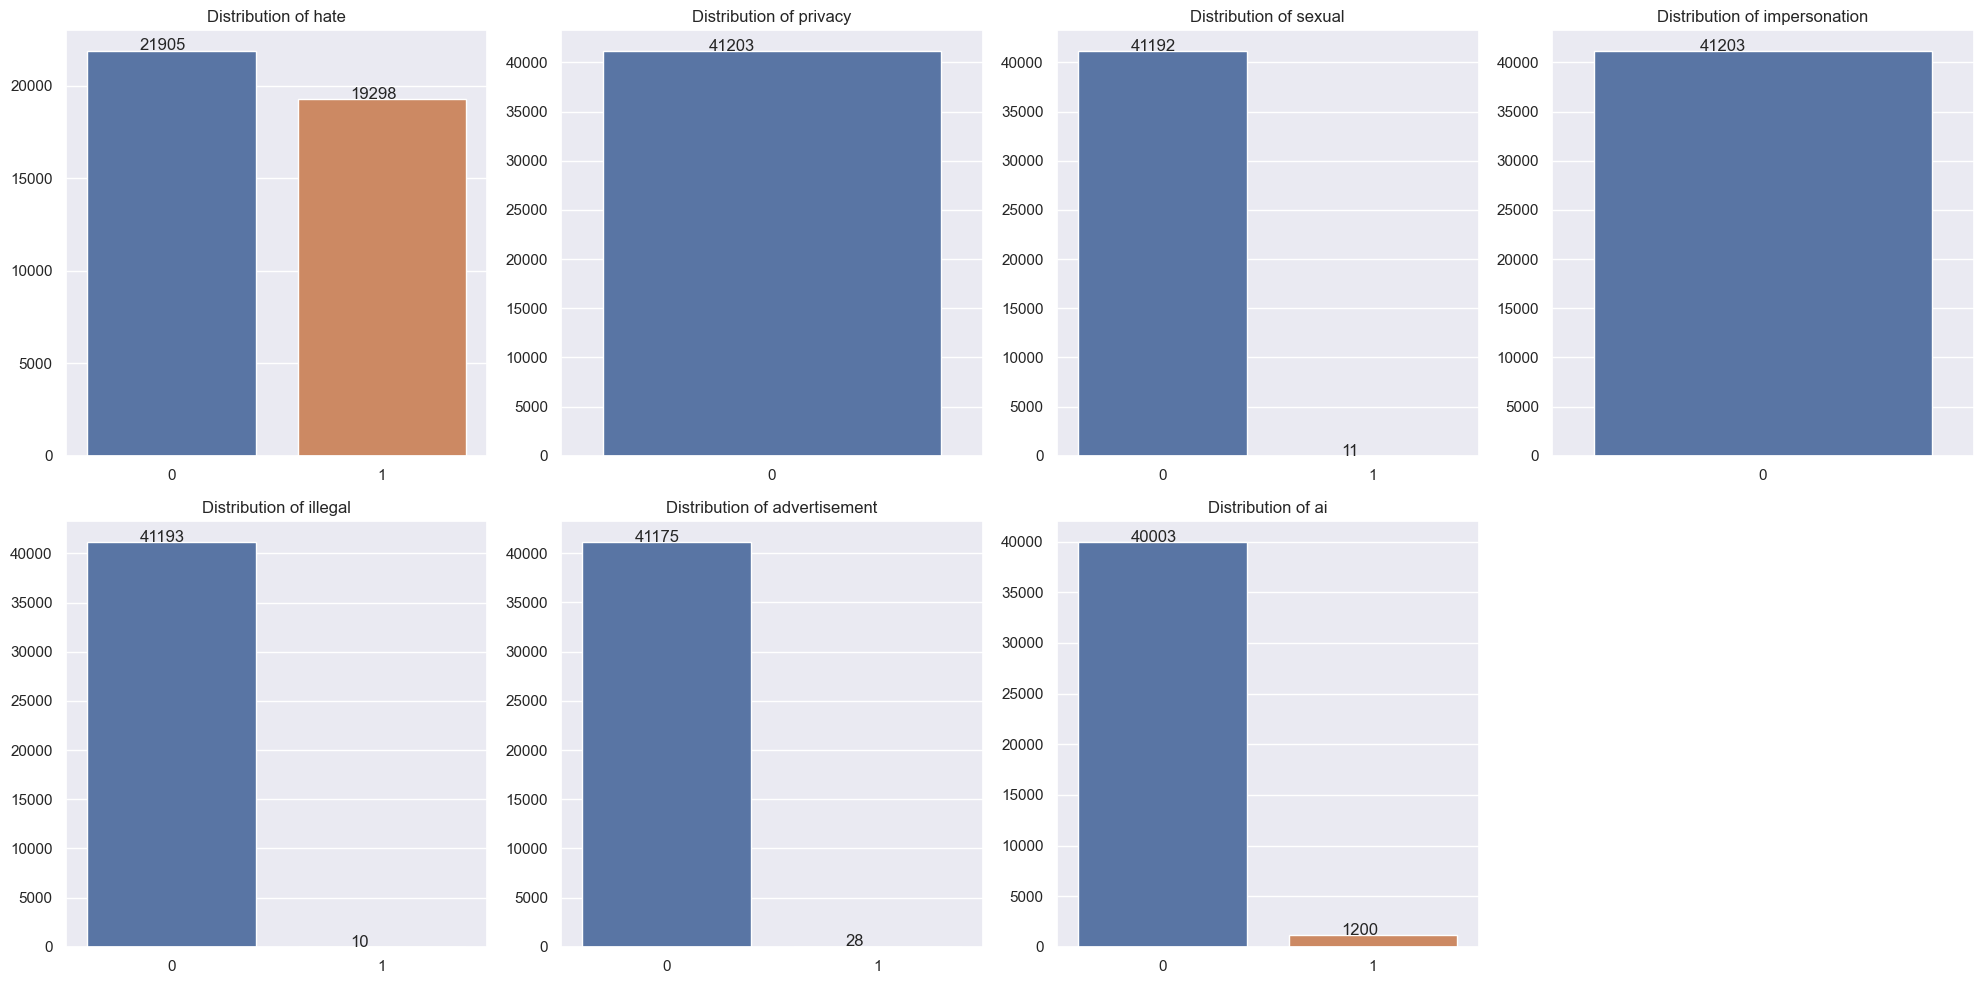

In [4]:
# Plotting the distribution of the target variables

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    if i < 7:
        sns.countplot(data=df, x=TARGET_VARS[i], ax=ax)
        ax.set_title(f'Distribution of {TARGET_VARS[i]}')
        ax.set_xlabel('')
        ax.set_ylabel('')
        # add counts to the bars
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}',
                        (p.get_x()+0.25, p.get_height()+13))

    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

### Textual Exploration

#### N-Gram Analysis

In [5]:
# Calculating frequencies of n-grams

def n_gram_frequencies(text, n):

    # Splitting text into words
    words = str(text).split()

    # Creating n-grams
    n_grams = zip(*[words[i:] for i in range(n)])

    # Calculating frequencies
    n_gram_freq = {}
    for n_gram in n_grams:
        n_gram = " ".join(n_gram)
        if n_gram in n_gram_freq:
            n_gram_freq[n_gram] += 1
        else:
            n_gram_freq[n_gram] = 1

    return n_gram_freq


def combine_n_gram_dicts_row_wise(n_gram_dict, combined_dict):
    for key, value in n_gram_dict.items():
        if key in combined_dict:
            combined_dict[key] += value
        else:
            combined_dict[key] = value
    return n_gram_dict


def generate_n_gram_dicts(df):
    all_data_1_gram = {}
    all_data_2_gram = {}
    all_data_3_gram = {}
    df["n-grams_1"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_1_gram))
    df["n-grams_2"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_2_gram))
    df["n-grams_3"].apply(lambda x: combine_n_gram_dicts_row_wise(x,
                          all_data_3_gram))
    return all_data_1_gram, all_data_2_gram, all_data_3_gram


def convert_dict_to_df(word_frequencies, min_freq=1):
    word_frequencies_df = pd.DataFrame.from_dict(
        word_frequencies, orient='index', columns=['Frequency'])
    word_frequencies_df = word_frequencies_df.sort_values(
        by='Frequency', ascending=False)
    word_frequencies_df = word_frequencies_df.reset_index().rename(columns={
        'index': 'Word'})
    word_frequencies_df = word_frequencies_df[word_frequencies_df['Frequency'] >= min_freq]
    return word_frequencies_df


def generate_wordcloud_from_freq(word_frequencies, var):
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=word_frequencies)
    # Display the generated image:
    fig, ax = plt.subplots(figsize=(16, 20))
    ax.imshow(wordcloud)
    plt.axis("off")
    plt.title(f"Word Cloud for {var}", fontsize=20)
    plt.show()


def generate_n_gram_analysis(df):
    for i in range(1, 4):
        df[f"n-grams_{i}"] = df["body"].apply(
            lambda x: n_gram_frequencies(x, i))

    # all data
    print("All Data")
    all_data_1_gram, all_data_2_gram, all_data_3_gram = generate_n_gram_dicts(
        df)
    print("All Data - 1-gram")
    display(convert_dict_to_df(all_data_1_gram).head(15))
    generate_wordcloud_from_freq(all_data_1_gram, "All Data - 1-gram")
    print("All Data - 2-gram")
    display(convert_dict_to_df(all_data_2_gram).head(15))
    generate_wordcloud_from_freq(all_data_2_gram, "All Data - 2-gram")
    print("All Data - 3-gram")
    display(convert_dict_to_df(all_data_3_gram).head(15))
    generate_wordcloud_from_freq(all_data_3_gram, "All Data - 3-gram")

    for var in TARGET_VARS:

        var_df = df[df[var] == 1]
        print(f"{var} data")
        var_1_gram, var_2_gram, var_3_gram = generate_n_gram_dicts(var_df)
        if var_1_gram:
            print(f"{var} data - 1-gram")
            display(convert_dict_to_df(var_1_gram).head(15))
            generate_wordcloud_from_freq(var_1_gram, f"{var} data - 1-gram")
        else:
            print(f"No 1-gram data for {var}. \n")

        if var_2_gram:
            print(f"{var} data - 2-gram")
            display(convert_dict_to_df(var_2_gram).head(15))
            generate_wordcloud_from_freq(var_2_gram, f"{var} data - 2-gram")
        else:
            print(f"No 2-gram data for {var}. \n")

        if var_3_gram:
            print(f"{var} data - 3-gram")
            display(convert_dict_to_df(var_3_gram).head(15))
            generate_wordcloud_from_freq(var_3_gram, f"{var} data - 3-gram")
        else:
            print(f"No 3-gram data for {var}. \n")

        print("=================================================================================================")

All Data
All Data - 1-gram


Word  Frequency
0     bitch       8132
1        rt       7582
2      like       5872
3        im       3701
4       get       3376
5   bitches       3046
6      dont       2965
7       one       2668
8      hoes       2335
9      time       2142
10    would       2137
11      got       2126
12    pussy       2076
13     good       2076
14   people       1964

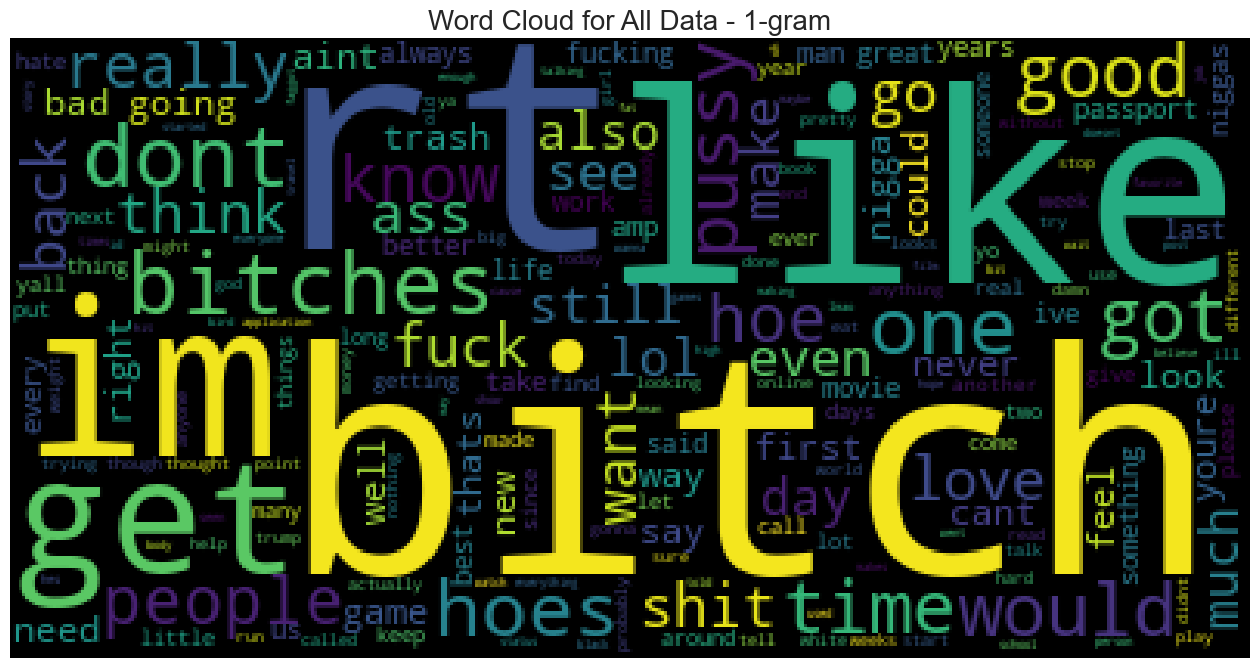

All Data - 2-gram


Word  Frequency
0     feel like        333
1     look like        271
2     dont know        242
3     bitch ass        234
4    looks like        224
5    like bitch        208
6      yo bitch        189
7     ass bitch        184
8     bad bitch        176
9      bitch im        148
10   first time        147
11    dont want        147
12    dont like        146
13   bitch dont        142
14  bad bitches        141

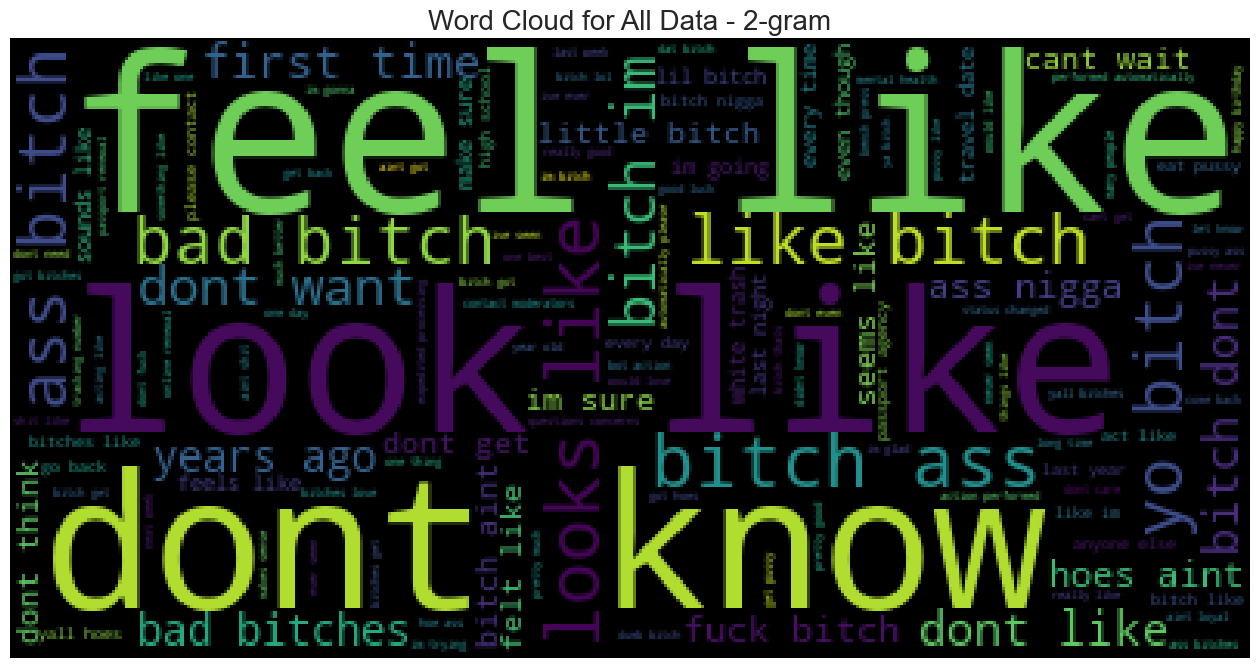

All Data - 3-gram


Word  Frequency
0                        automatically please contact         81
1                                bot action performed         81
2                           please contact moderators         81
3                      performed automatically please         81
4                      action performed automatically         81
5                                     hoes aint loyal         64
6                                     bitch ass nigga         53
7                         violations result permanent         47
8                             shill troll accusations         47
9                             accusations hate speech         47
10                            posted subreddit please         47
11                             subreddit please click         47
12  please click herehttpswwwredditcomrpoliticswik...         47
13  click herehttpswwwredditcomrpoliticswikiapprov...         47
14                             troll accusations hate         47

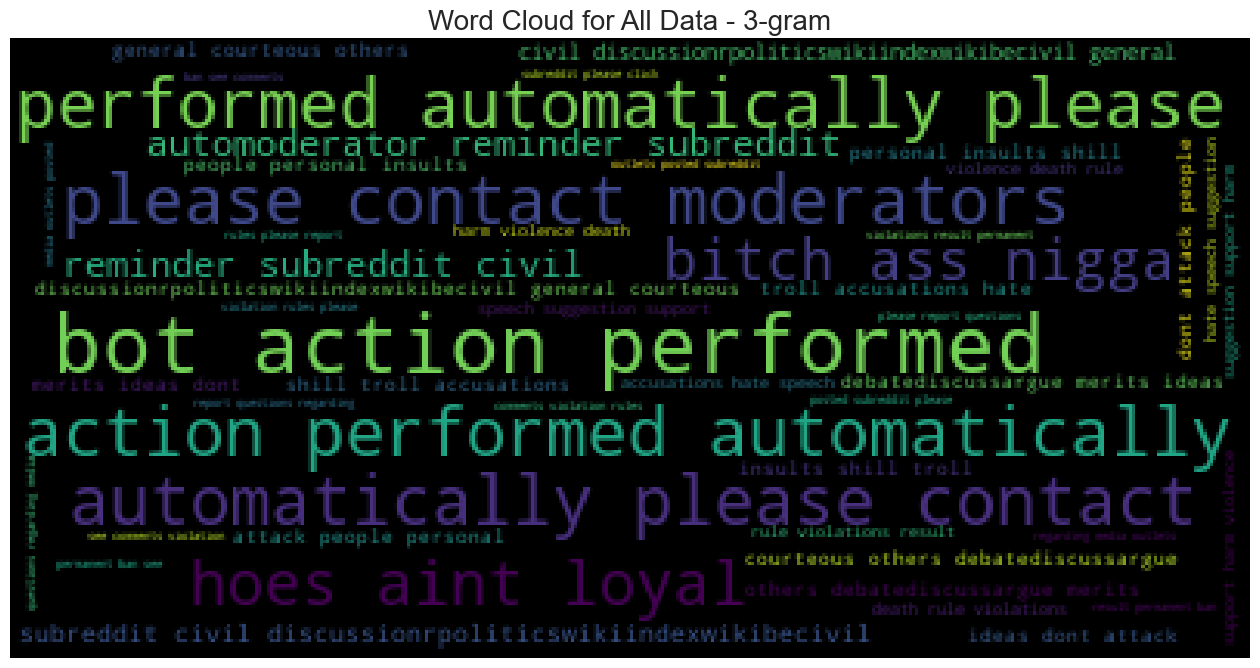

hate data
hate data - 1-gram


Word  Frequency
0     bitch       7904
1        rt       5943
2   bitches       2989
3      like       2303
4      hoes       2266
5     pussy       2019
6       hoe       1794
7        im       1753
8      dont       1492
9       ass       1426
10     fuck       1332
11      get       1230
12     shit       1194
13      got       1143
14     aint       1089

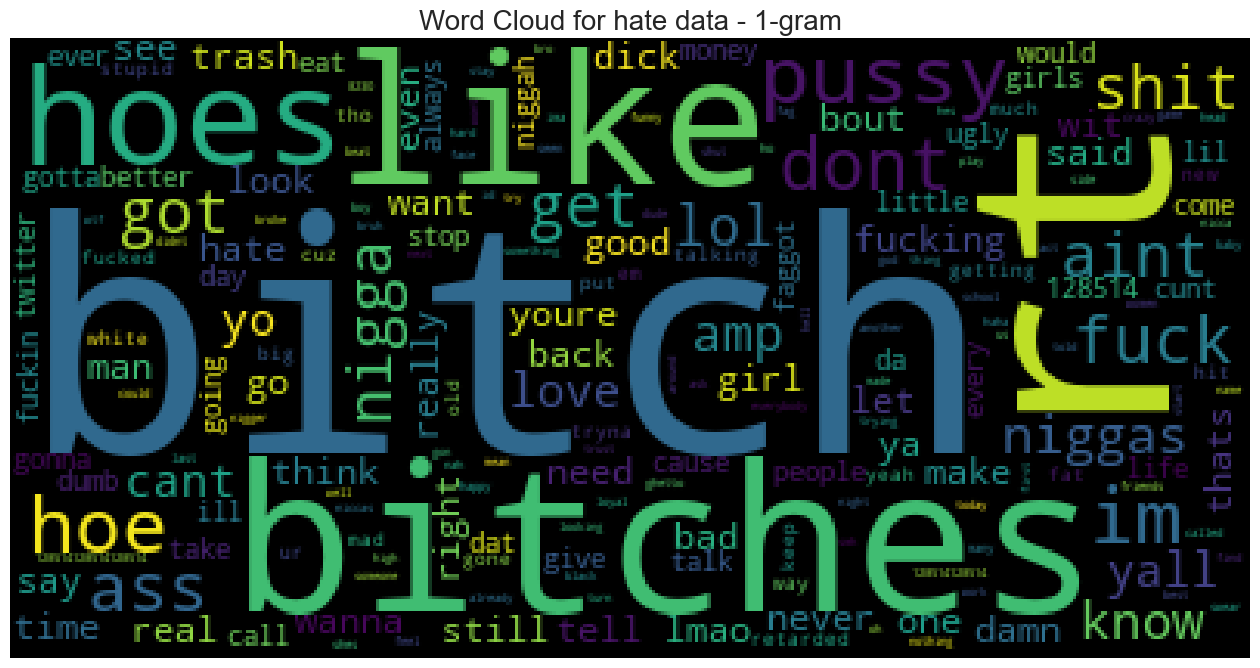

hate data - 2-gram


Word  Frequency
0      bitch ass        220
1     like bitch        199
2       yo bitch        185
3      ass bitch        177
4      bad bitch        175
5      look like        152
6       bitch im        144
7    bad bitches        140
8     bitch dont        136
9      hoes aint        124
10  little bitch        117
11    fuck bitch        117
12    bitch aint        108
13     ass nigga        107
14     lil bitch         93

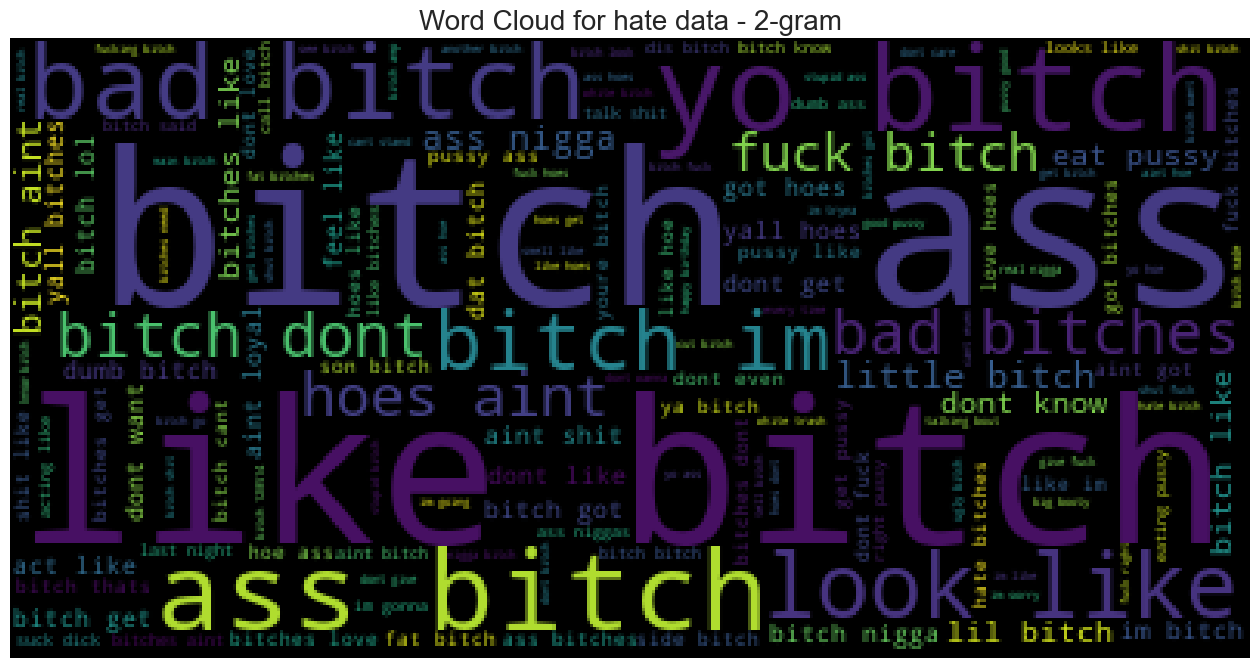

hate data - 3-gram


Word  Frequency
0      hoes aint loyal         64
1      bitch ass nigga         46
2       dont love hoes         31
3      bitch look like         24
4     fuck right pussy         23
5     stupid ass bitch         23
6         yo bitch ass         22
7   bitches thing like         21
8    bad bitches thing         20
9       ass bitch aint         19
10      dont give fuck         19
11       hoe ass nigga         18
12   bitches aint shit         17
13      cunt cunt cunt         13
14   like little bitch         13

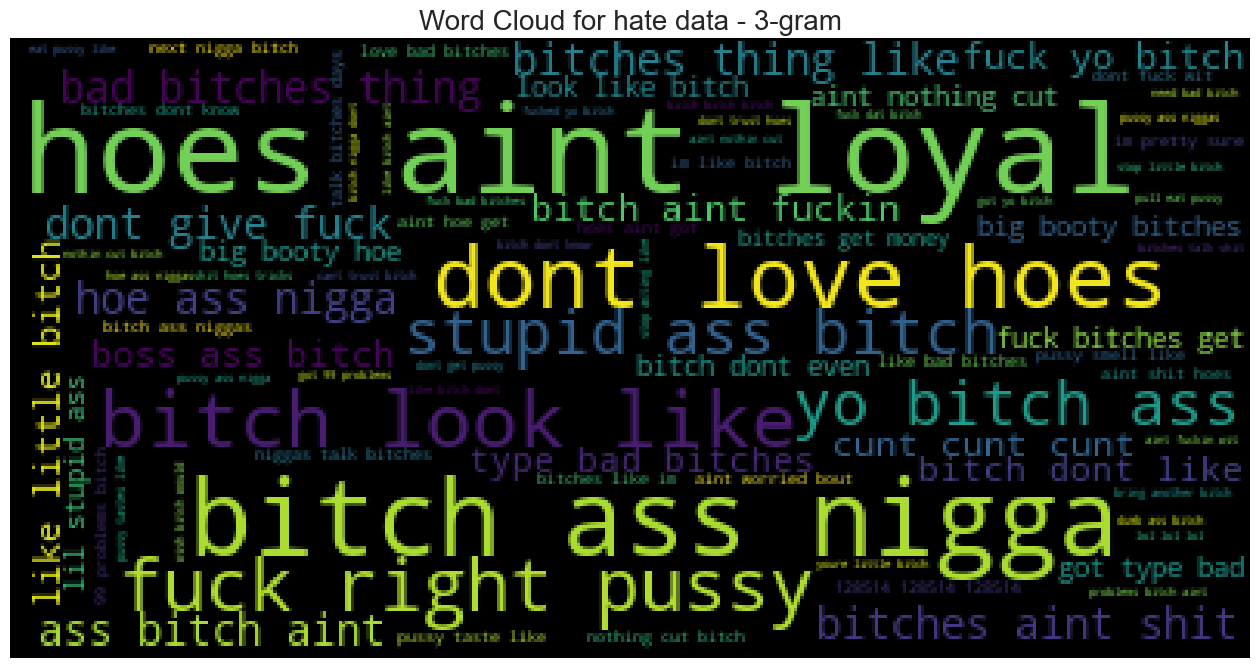

privacy data
No 1-gram data for privacy. 

No 2-gram data for privacy. 

No 3-gram data for privacy. 

sexual data
sexual data - 1-gram


Word  Frequency
0      good          8
1       sex          6
2     story          6
3   romance          6
4     adult          6
5       new          6
6   fantasy          4
7      like          4
8        im          4
9      feel          4
10     smut          4
11    books          3
12     find          3
13       ya          3
14   series          3

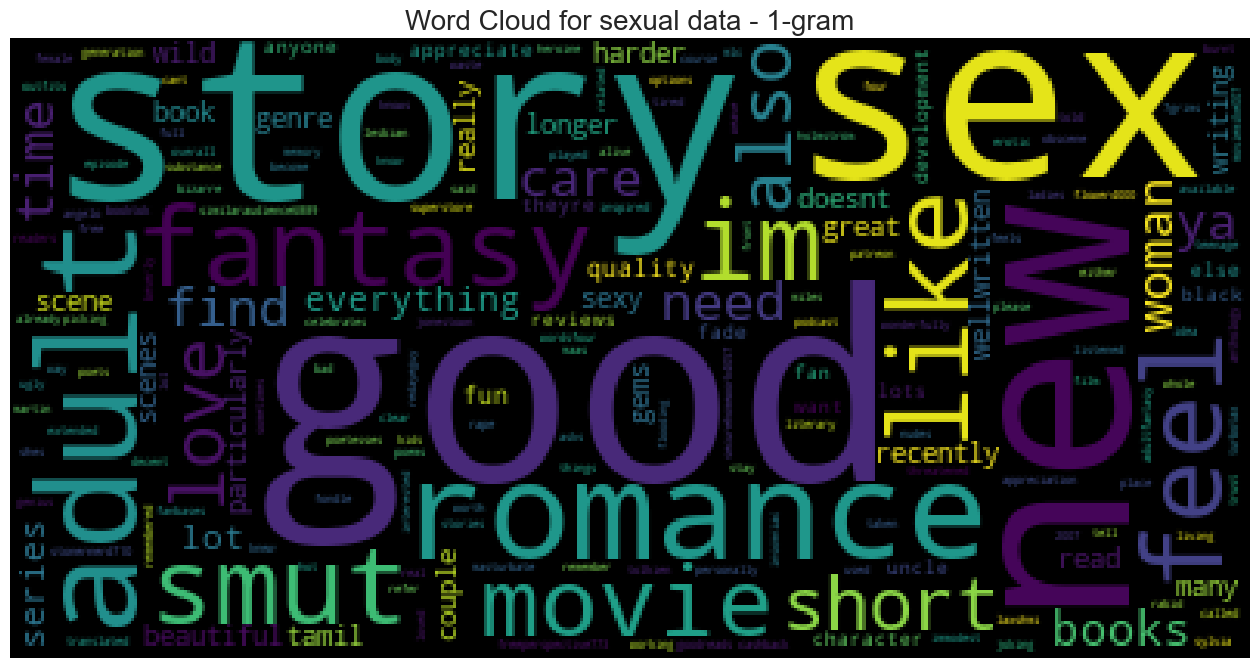

sexual data - 2-gram


Word  Frequency
0               new adult          4
1               feel like          3
2              fade black          2
3             anyone else          2
4               else feel          2
5         appreciate good          2
6                 like ya          2
7                  ya sex          2
8        woman appreciate          2
9               fun woman          2
10              adult fun          2
11        fantasy romance          2
12             good story          2
13  character development          2
14              good smut          2

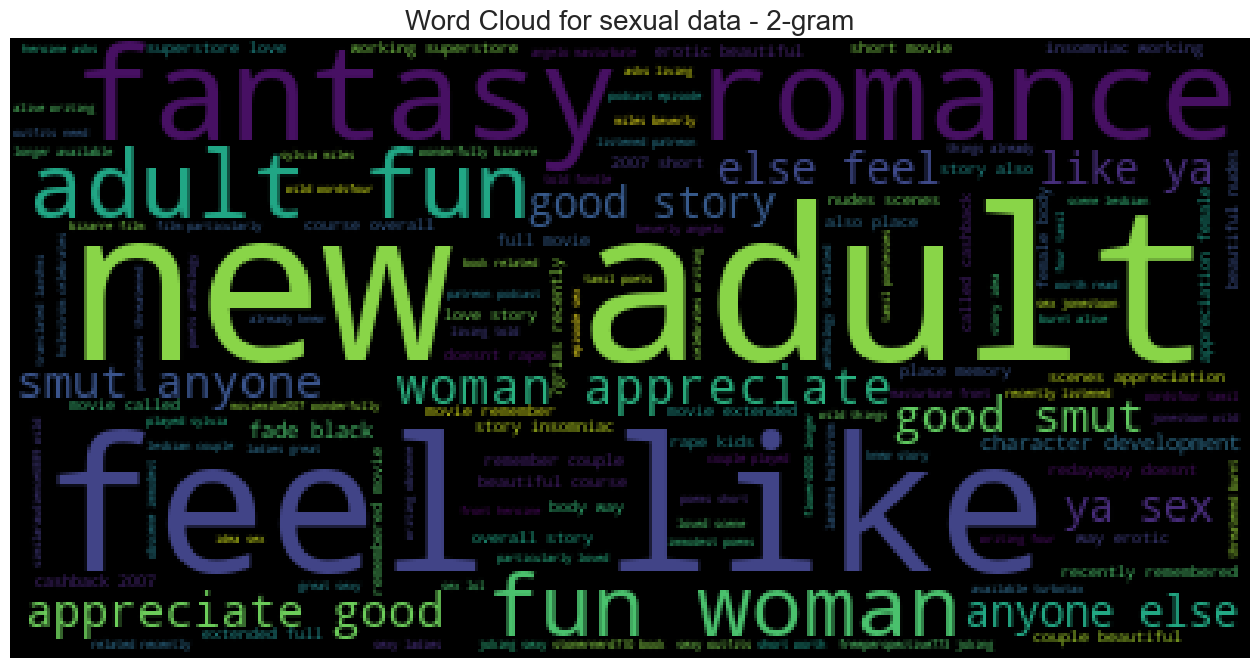

sexual data - 3-gram


Word  Frequency
0    fun woman appreciate          2
1             like ya sex          2
2            feel like ya          2
3          else feel like          2
4        anyone else feel          2
5        smut anyone else          2
6        good smut anyone          2
7    appreciate good smut          2
8   woman appreciate good          2
9         adult fun woman          2
10          new adult fun          2
11  sword actually cursed          1
12        iirc sex scenes          1
13       warrior iirc sex          1
14    cursed warrior iirc          1

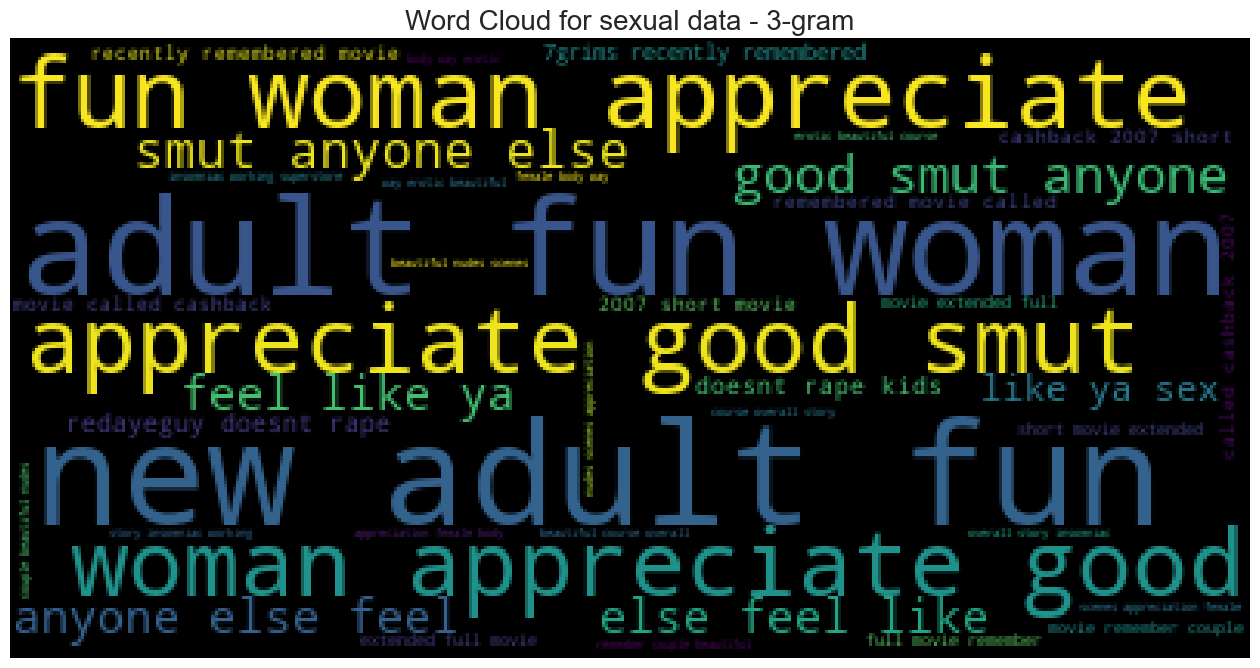

impersonation data
No 1-gram data for impersonation. 

No 2-gram data for impersonation. 

No 3-gram data for impersonation. 

illegal data
illegal data - 1-gram


Word  Frequency
0           fuck          3
1           pedo          3
2           shit          3
3            fix          3
4         around          2
5           like          2
6   distributing          1
7          child          1
8       luckiest          1
9            guy          1
10          make          1
11      actually          1
12         might          1
13      happened          1
14    assaulting          1

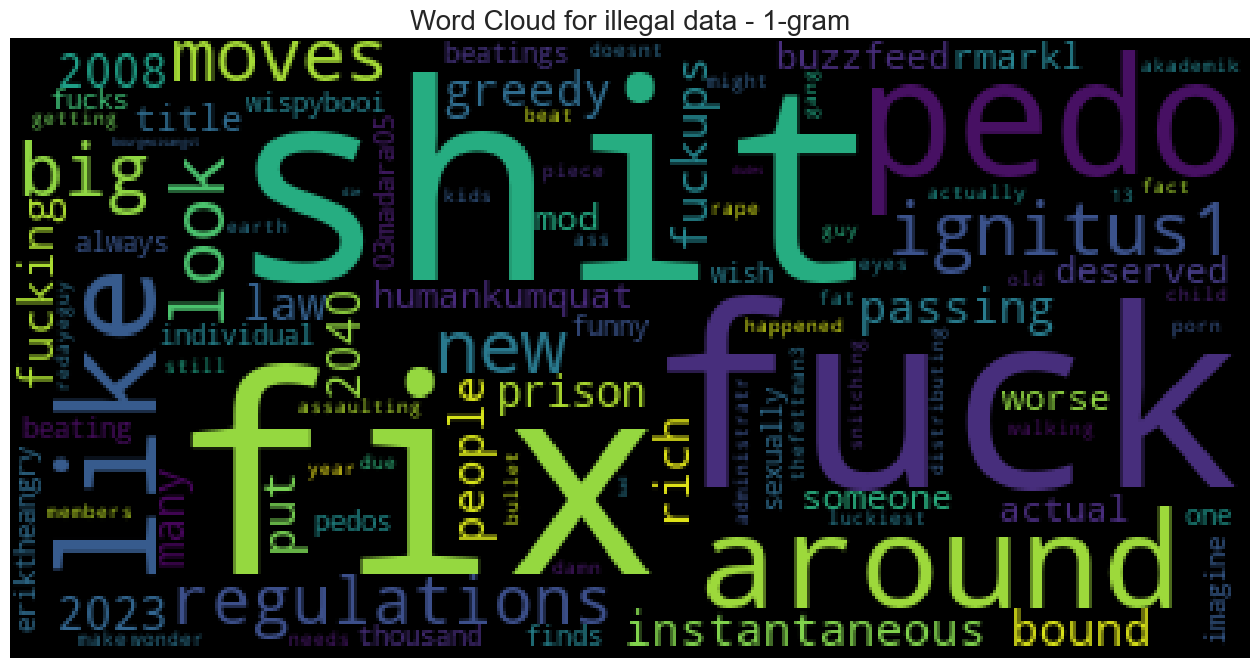

illegal data - 2-gram


Word  Frequency
0        ignitus1 look          1
1       snitching gang          1
2       might actually          1
3       happened might          1
4        fact happened          1
5            like fact          1
6          around like          1
7       walking around          1
8        still walking          1
9        members still          1
10        gang members          1
11      porn snitching          1
12            make guy          1
13          child porn          1
14  distributing child          1

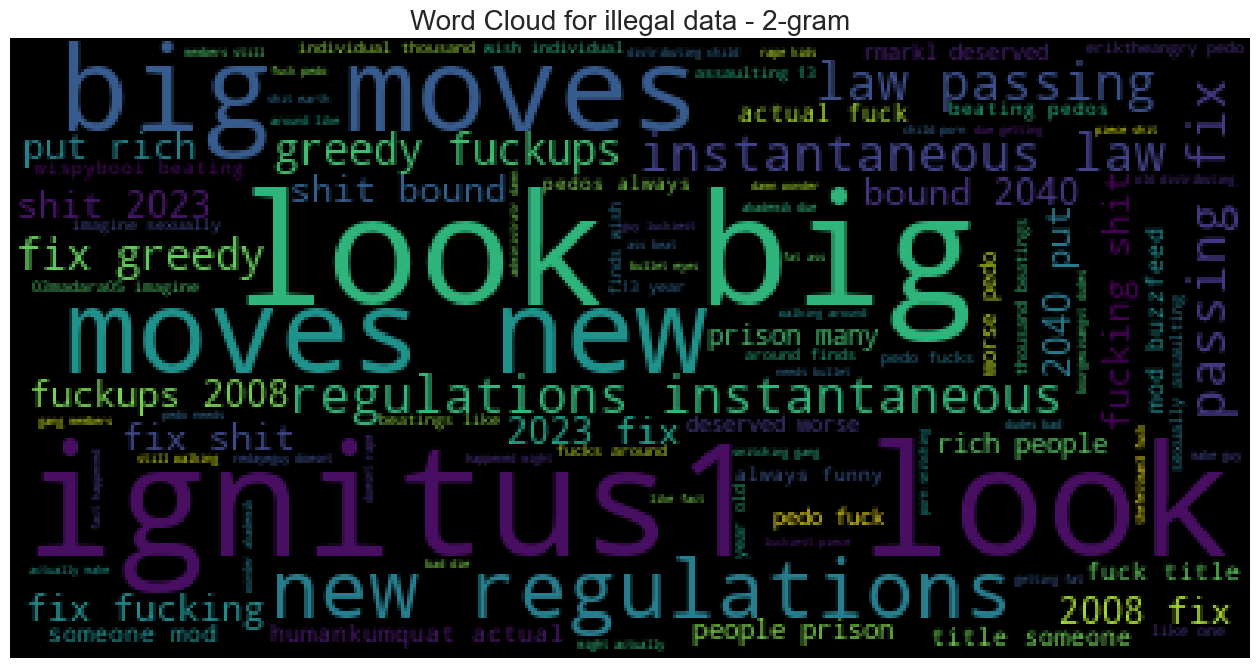

illegal data - 3-gram


Word  Frequency
0         ignitus1 look big          1
1       porn snitching gang          1
2       fact happened might          1
3        like fact happened          1
4          around like fact          1
5       walking around like          1
6      still walking around          1
7     members still walking          1
8        gang members still          1
9    snitching gang members          1
10     child porn snitching          1
11           look big moves          1
12  distributing child porn          1
13   old distributing child          1
14    year old distributing          1

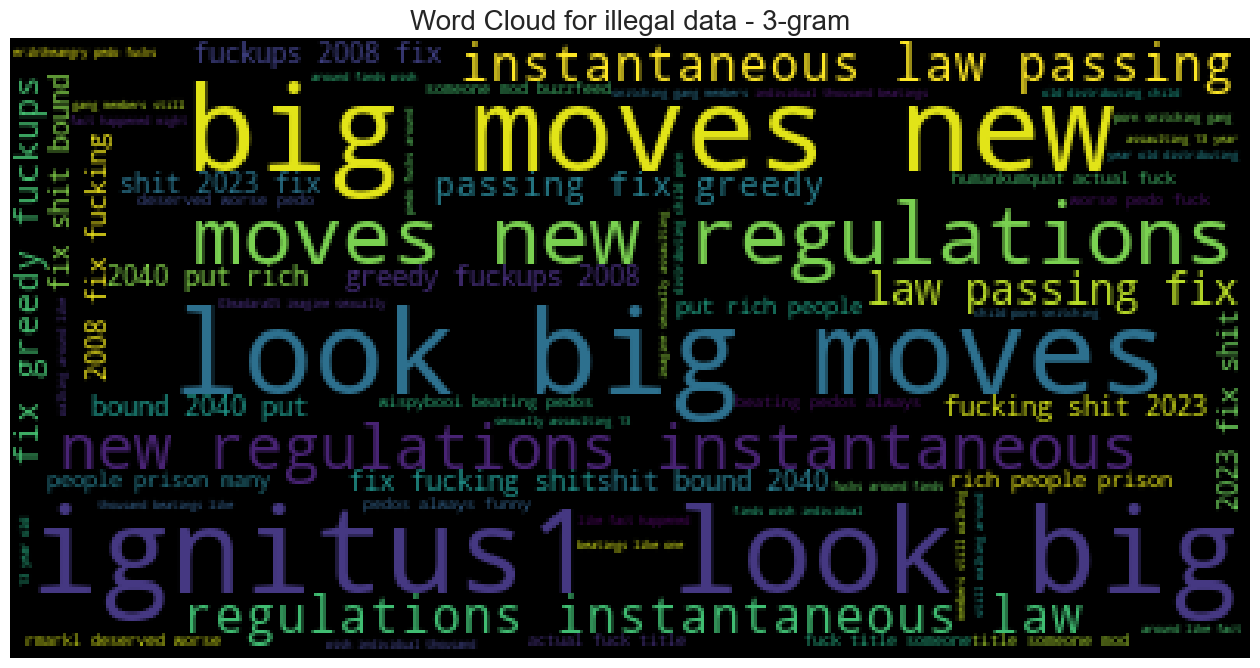

advertisement data
advertisement data - 1-gram


Word  Frequency
0   pandabuy         47
1     taobao         30
2   shipping         29
3     career         24
4        use         24
5        dhl         24
6      x200b         24
7       haul         21
8     parcel         20
9       help         20
10     guide         20
11     agent         20
12   customs         19
13    search         17
14      time         17

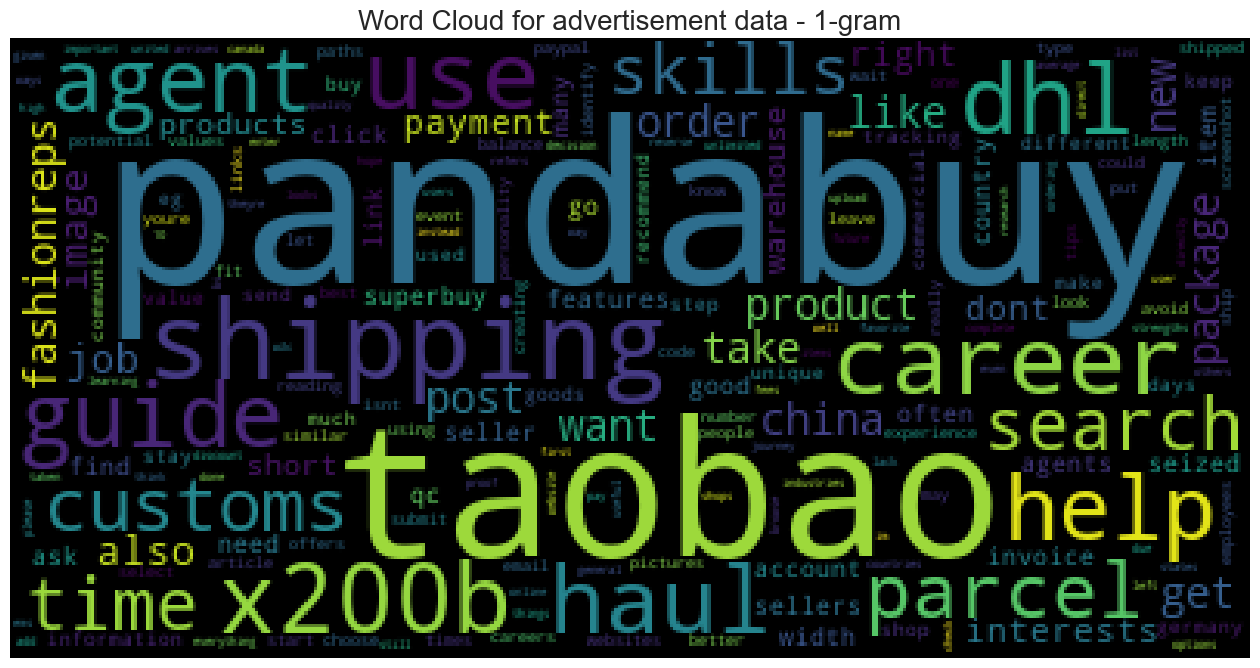

advertisement data - 2-gram


Word  Frequency
0   commercial invoice          8
1       pandabuy guide          7
2           china post          6
3          often times          6
4      unique features          6
5         career paths          5
6        proof payment          5
7         image search          5
8     interests skills          4
9        reverse image          4
10       united states          4
11          looks like          4
12      employees want          4
13   pandabuy pandabuy          4
14         dhl express          4

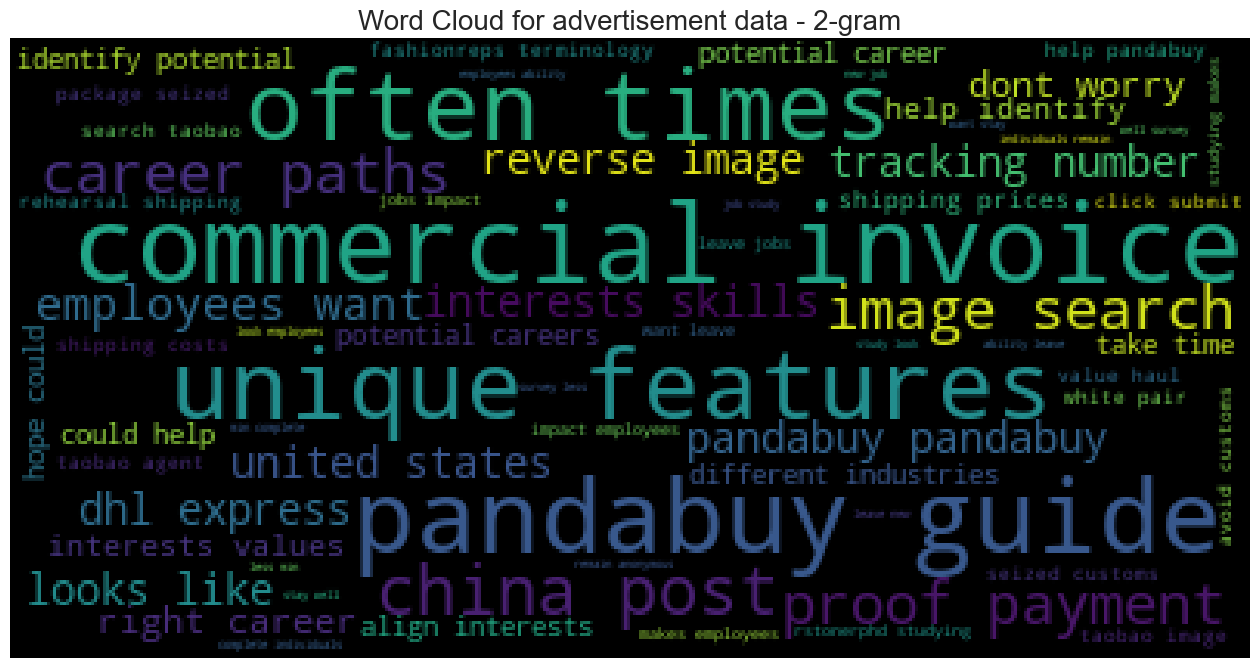

advertisement data - 3-gram


Word  Frequency
0       reverse image search          4
1     potential career paths          3
2            hope could help          3
3    help identify potential          3
4        image search taobao          3
5          make haul cheaper          2
6        express hotline ask          2
7          hotline ask email          2
8            ask email proof          2
9        email proof payment          2
10  proof payment screenshot          2
11         xi shipped parcel          2
12       links seller stores          2
13          call dhl express          2
14       useful links seller          2

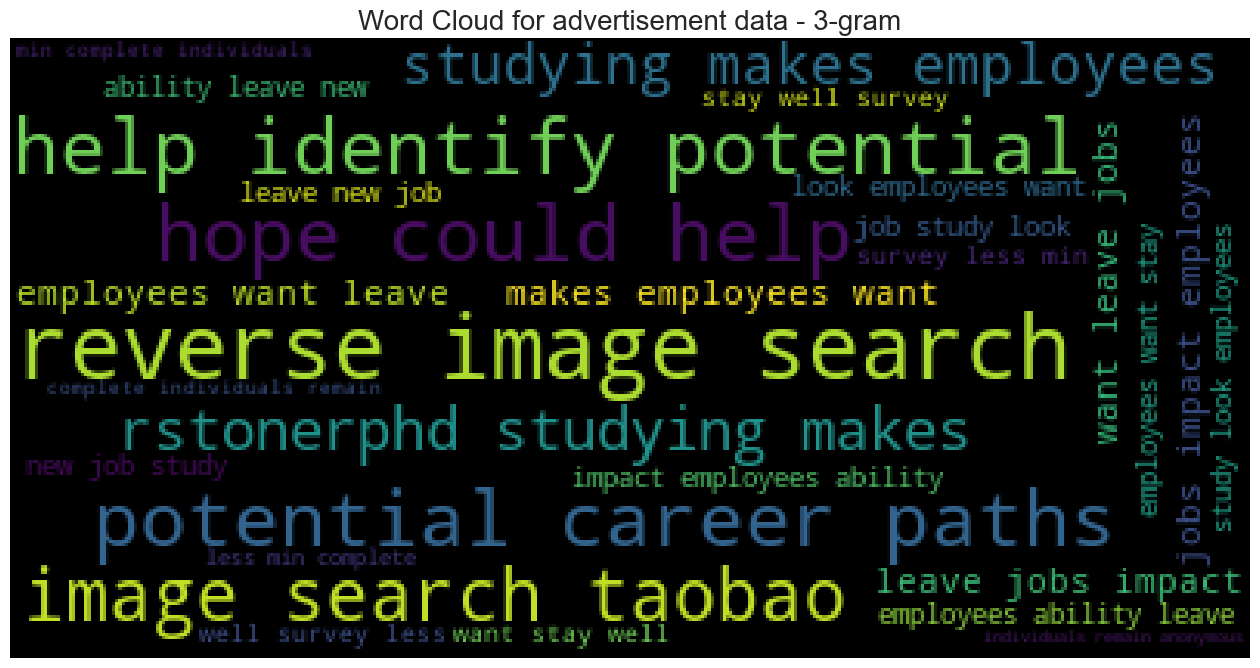

ai data
ai data - 1-gram


Word  Frequency
0             im        109
1           love        103
2            new         91
3       favorite         86
4           life         85
5           cant         84
6           time         71
7        feeling         61
8           like         59
9           good         53
10          make         51
11        always         51
12           way         47
13     important         47
14  architecture         46

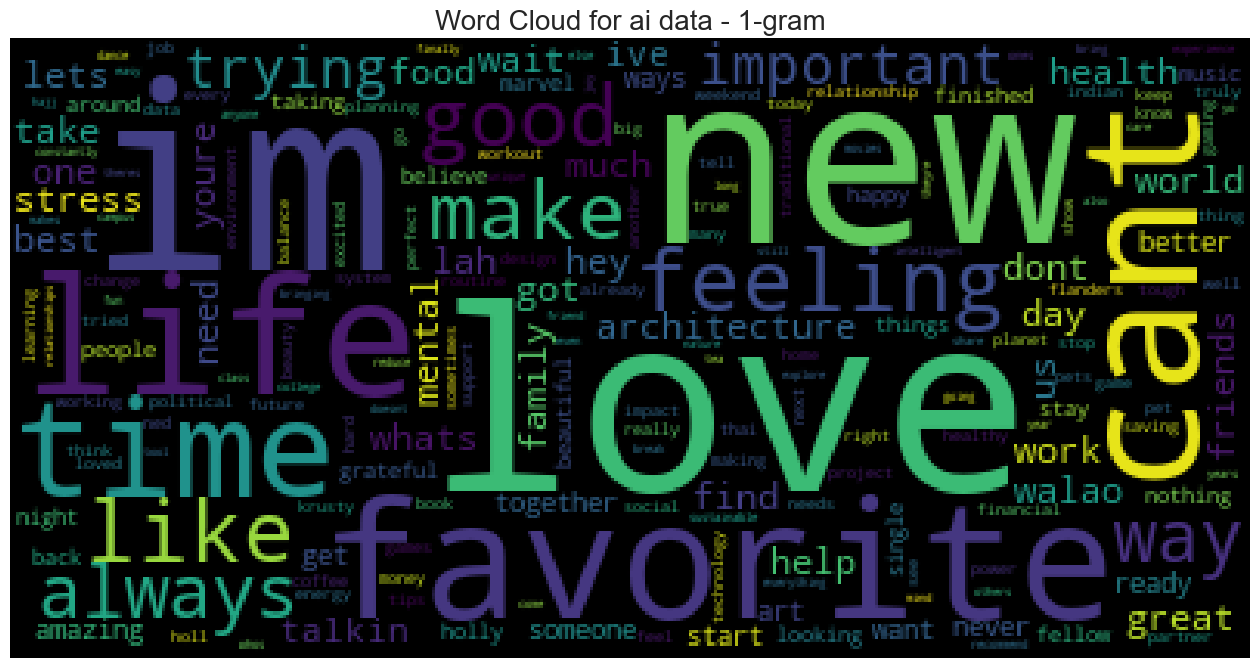

ai data - 2-gram


Word  Frequency
0            cant wait         32
1        mental health         27
2       whats favorite         22
3         cant believe         17
4           trying new         16
5           holly holl         15
6            great way         15
7         ned flanders         15
8            im always         14
9   intelligent system         13
10         true marvel         12
11           feel like         11
12          loved ones         10
13    feeling grateful         10
14             hey hey         10

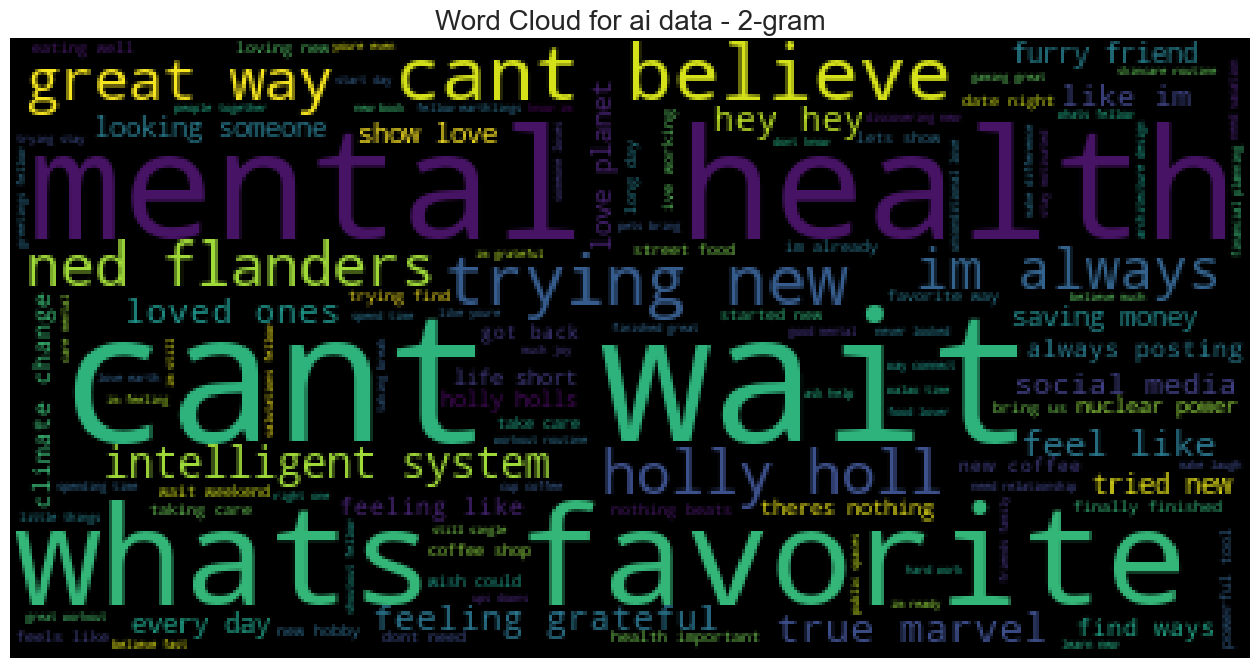

ai data - 3-gram


Word  Frequency
0              feel like im          7
1         cant wait weekend          6
2        whats favorite way          5
3           new coffee shop          5
4    finished great workout          4
5         great way connect          4
6          holl true marvel          4
7           holly holl true          4
8   mental health important          4
9        good mental health          4
10        cant believe much          4
11         gaming great way          4
12       care mental health          4
13          love earth love          4
14         trying new hobby          4

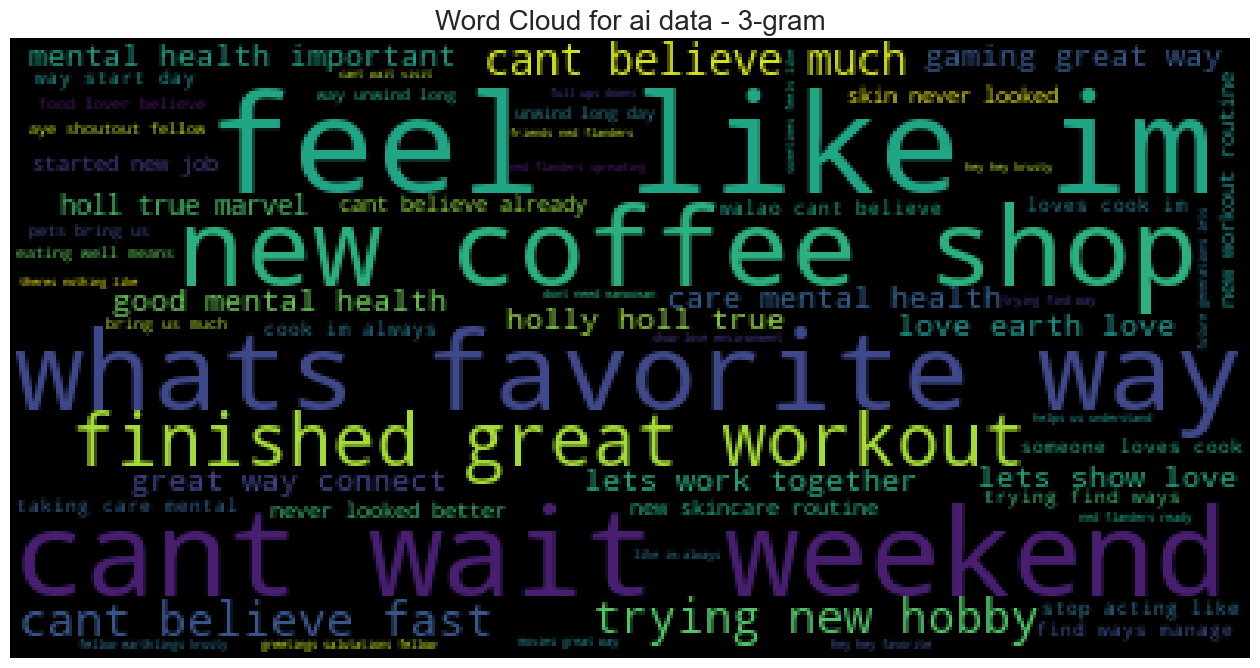

In [6]:
generate_n_gram_analysis(df)

## Cluster Analysis

- Document level analysis
- Word level analysis

#### Document Level Analysis

In [5]:
df

body  hate  privacy  \
0      kalleron design refuse collection recycling si...     0        0   
1      hotmeringue2880 hi economics graduate years ex...     0        0   
2      milenakowalska hey year finish bachelor degree...     0        0   
3      rstonerphd studying makes employees want leave...     0        0   
4      temporarysection50 hi accepted job offer earli...     0        0   
...                                                  ...   ...      ...   
41198  yous muthafin lie 8220lifeasking 20pearls core...     1        0   
41199  youve gone broke wrong heart baby drove rednec...     0        0   
41200  young buck wanna eat dat nigguh like aint fuck...     1        0   
41201                  youu got wild bitches tellin lies     1        0   
41202  ruffled ntac eileen dahlia beautiful color com...     0        0   

       sexual  impersonation  illegal  advertisement  ai  
0           0              0        0              0   0  
1           0              0        0              0   0  
2           0              0        0              0   0  
3           0              0        0              1   0  
4           0              0        0              0   0  
...       ...            ...      ...            ...  ..  
41198       0              0        0              0   0  
41199       0              0        0              0   0  
41200       0              0        0              0   0  
41201       0              0        0              0   0  
41202       0              0        0              0   0  

[41203 rows x 8 columns]

In [27]:
def elbow_method_clustering(text):
    vectorizer = TfidfVectorizer(stop_words=list(STOP_WORDS))
    X = vectorizer.fit_transform(text)
    Sum_of_squared_distances = []
    K = range(2,10)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    plt.figure(figsize=(10, 8))
    sns.lineplot(x=K, y=Sum_of_squared_distances, marker=True)
    # plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()        
    return X

def cluster_text(text, X, n_clusters=5):
    model = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=200, n_init=10)
    model.fit(X)

    labels=model.labels_
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
    #print(clusters.sort_values(by=['cluster']))

    return clusters


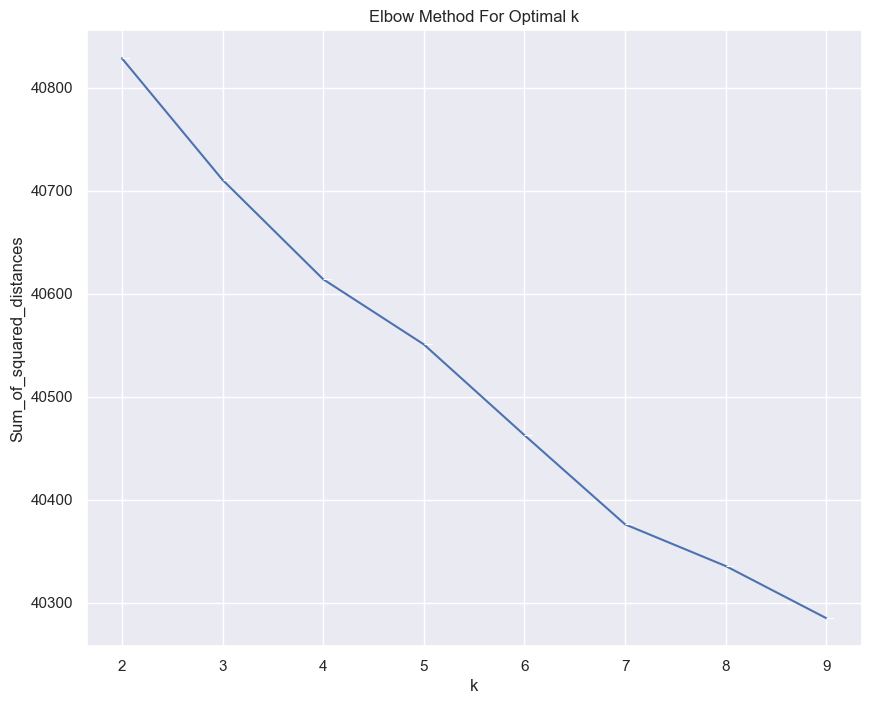

In [28]:
X = elbow_method_clustering(df['body'])

In [29]:
cluster_df = cluster_text(df['body'], X, n_clusters=4)

In [33]:
for cluster in range(4):
    print(f"Cluster {cluster}")
    display(cluster_df[cluster_df['cluster'] == cluster].head(15))
    print("=================================================================================================")

Cluster 0


title  cluster
7670   lordclooch thats happens bitches throw gang signs        0
16427  8220selfiequeenbri cause im tired big bitches ...        0
16433                             bad bitches thing like        0
16438                           bitches get cut everyday        0
16451  id say im back old old bitches would get excit...        0
16454  im done bitter bitches wrap angry bird theres app        0
16457             jus meet son ya mane ass bitches shots        0
16468                bitches even worst theyll send guys        0
16470                          dont trust niggas bitches        0
16471  yall niggas cuffing hoes cause yall aint never...        0
16472  dodge bullet 128517 8220darealkha da bitches c...        0
16473          young pill chamberlain bitches love music        0
16475  1285141285141285141285141285141285141285141285...        0
16479  wanna get money fuck model bitches russell sim...        0
16484  adorebellaaa ya ever asked bitch bitches kanye...        0

Cluster 1


title  cluster
1235                              dyringatory dont pussy        1
8347   riskyshot attacked sauna cuz hes unlikely gun ...        1
16425  tmadisonx shit blows meclaim faithful somebody...        1
16432                        hoes smoke losers yea go ig        1
16442                          cant see hoes wont change        1
16445                pussy lips like heaven doors 128524        1
16447          met pussy ocean dr gave pussy pill 128524        1
16452             aint bout murder game pussy nigga shut        1
16453                  youre toes aint done pussy stinks        1
16458                lames crying hoes thats tears clown        1
16459                  like snoop said 94 dont love hoes        1
16460              momma said pussy cats inside doghouse        1
16461  hated hoes favorite 2mw sevenone httptcobmdsvm...        1
16463                      pimps pimps hoes future voice        1
16464                   post picture pussy get 200 likes        1

Cluster 2


title  cluster
7744            m0derat0r41 pedo bitch nine still prison        2
10078  yyzsteven sounds like quintessential toxic cor...        2
13485                     al3x5 ass kicking outfit bitch        2
14249  cabinguy11 freely admit dont understand ins ou...        2
16422  rt urkindofbrand dawg rt 80sbaby4life ever fuc...        2
16424  rt shenikaroberts shit hear might true might f...        2
16426  brighterdays sit hate another bitch got much s...        2
16428              amp might get ya bitch back amp thats        2
16429    rhythmixx hobbies include fighting mariam bitch        2
16430  keeks bitch curves everyone lol walked convers...        2
16431                         murda gang bitch gang land        2
16434                                          bitch get        2
16435                                   bitch nigga miss        2
16436                                 bitch plz whatever        2
16437                                         bitch love        2

Cluster 3


title  cluster
0   kalleron design refuse collection recycling si...        3
1   hotmeringue2880 hi economics graduate years ex...        3
2   milenakowalska hey year finish bachelor degree...        3
3   rstonerphd studying makes employees want leave...        3
4   temporarysection50 hi accepted job offer earli...        3
5   glitterenthusiast congratulations new role sup...        3
6   account1998 career opportunities position star...        3
7   quitaquites well everyone role past years stal...        3
8   innietobby interview job really want next week...        3
9   monkeyparadiso find ways simulate experience k...        3
10  vikassharma7202 trouble finding job lack exper...        3
11  vikassharma7202 youre someone enjoys gaming cr...        3
12  bonez656 hello rcareerguidance ive added new a...        3
13  musiclovermina think cool dont know requiremen...        3
14  awwjeezec132 posted really dont want post loca...        3

#### Word Level Analysis

In [46]:
# Constructing dictionary of unique words from raw text

def construct_dictionary(text, combined_dict):

    # Constructing dictionary
    for word in text.split():
        if word not in combined_dict:
            combined_dict[word] = len(combined_dict)

    return combined_dict

def generate_dict(df):
    output_dict = {}
    df["body"].apply(lambda x: construct_dictionary(x, output_dict))
    return output_dict

# Download and pickle pre-trained model

def download_model(model_name):
    time_start = time.time()
    model = api.load(model_name)
    print(f"INFO: model loaded in {time.time() - time_start} seconds")
    with open(f"cache_files/{model_name}.pickle", "wb") as f:
        pickle.dump(model, f)

def load_model(model_name):
    with open(f"cache_files/{model_name}.pickle", "rb") as f:
        model = pickle.load(f)
    return model

# Get embeddings from pre-trained model

def get_embeddings(model, word):
    if model.__contains__(word):
        return np.array(model[word])
    else:
        return None

# Transforming text to vector using a pre-trained model glove-wiki-gigaword-50

def transform_text_to_vector(dictionary):
    
    # Transforming text to vector
    try:
        model = load_model("glove-wiki-gigaword-50")
        print("INFO: glove-wiki-gigaword-50 loaded.")
    except:
        print("INFO: Downloading glove-wiki-gigaword-50 loaded.")
        download_model("glove-wiki-gigaword-50")
        model = load_model("glove-wiki-gigaword-50")
        print("INFO: glove-wiki-gigaword-50 loaded.")


    vectorised_text = {}
    print("INFO: Transforming text to vector.")
    for word in dictionary.keys():
        if get_embeddings(model, word) is not None:
            vectorised_text[word] = get_embeddings(model, word)

    return vectorised_text

# Clustering vectors using k-means

def cluster_vectors(vectorised_text, n_clusters=3, n_samples=100):

    # Clustering vectors
    print(f"INFO: Clustering vectors using k-means for n_clusters = {n_clusters}.")    
    kmeans = KMeans(n_clusters=n_clusters, n_init='auto', random_state=42).fit(list(vectorised_text.values()))

    # Calculating within cluster sum of squares
    print("INFO: Calculating within cluster sum of squares.")
    wcss = kmeans.inertia_

    # Transforming vectors to 2D space for visualisation
    print("INFO: Transforming vectors to 2D space for visualisation.")
    tsne = TSNE(n_components=2, random_state=42, perplexity=50)
    vectors_2d = tsne.fit_transform(np.array(list(vectorised_text.values())))

    # Creating dataframe for visualisation
    print("INFO: Creating dataframe for visualisation.")
    vectors_2d = pd.DataFrame(vectors_2d, columns=['x', 'y'])
    vectors_2d['cluster'] = kmeans.labels_
    vectors_2d['word'] = list(vectorised_text.keys())

    # Sampling 100 points for visualisation
    print("INFO: Sampling 100 points for visualisation.")
    vectors_2d = vectors_2d.sample(min(n_samples, vectors_2d.shape[0]))
    vectors_2d = vectors_2d.reset_index(drop=True)

    # Visualising clusters
    print("INFO: Visualising clusters.")
    fig, ax = plt.subplots(figsize=(20, 20))
    sns.scatterplot(x='x', y='y', hue='cluster', data=vectors_2d, ax=ax)

    # annotating points
    for i, point in vectors_2d.iterrows():
        ax.text(point.x, point.y, point.word, fontsize=12)
        
    plt.title(f"Clusters of words for n_clusters = {n_clusters}", fontsize=20)
    plt.show()

    # Assigning cluster to each word
    print("INFO: Assigning cluster to each word.")
    for i, word in enumerate(vectorised_text.keys()):
        vectorised_text[word] = kmeans.labels_[i]
        
    return vectorised_text, vectors_2d, wcss

# Elbow method for determining optimal number of clusters

def elbow_method(df, max_clusters=10):
    dictionary = generate_dict(df)

    wcss = []
    for i in range(2, max_clusters+1):
        vectorised_text = transform_text_to_vector(dictionary)
        _, _, wcss_ = cluster_vectors(vectorised_text, n_clusters=i)
        wcss.append(wcss_)
    # plotting the results onto a line graph using seaborn

    plt.figure(figsize=(10, 10))
    sns.lineplot(x=range(1, max_clusters), y=wcss)
    plt.title('The elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS') # within cluster sum of squares
    plt.show()


INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 2.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Visualising clusters.


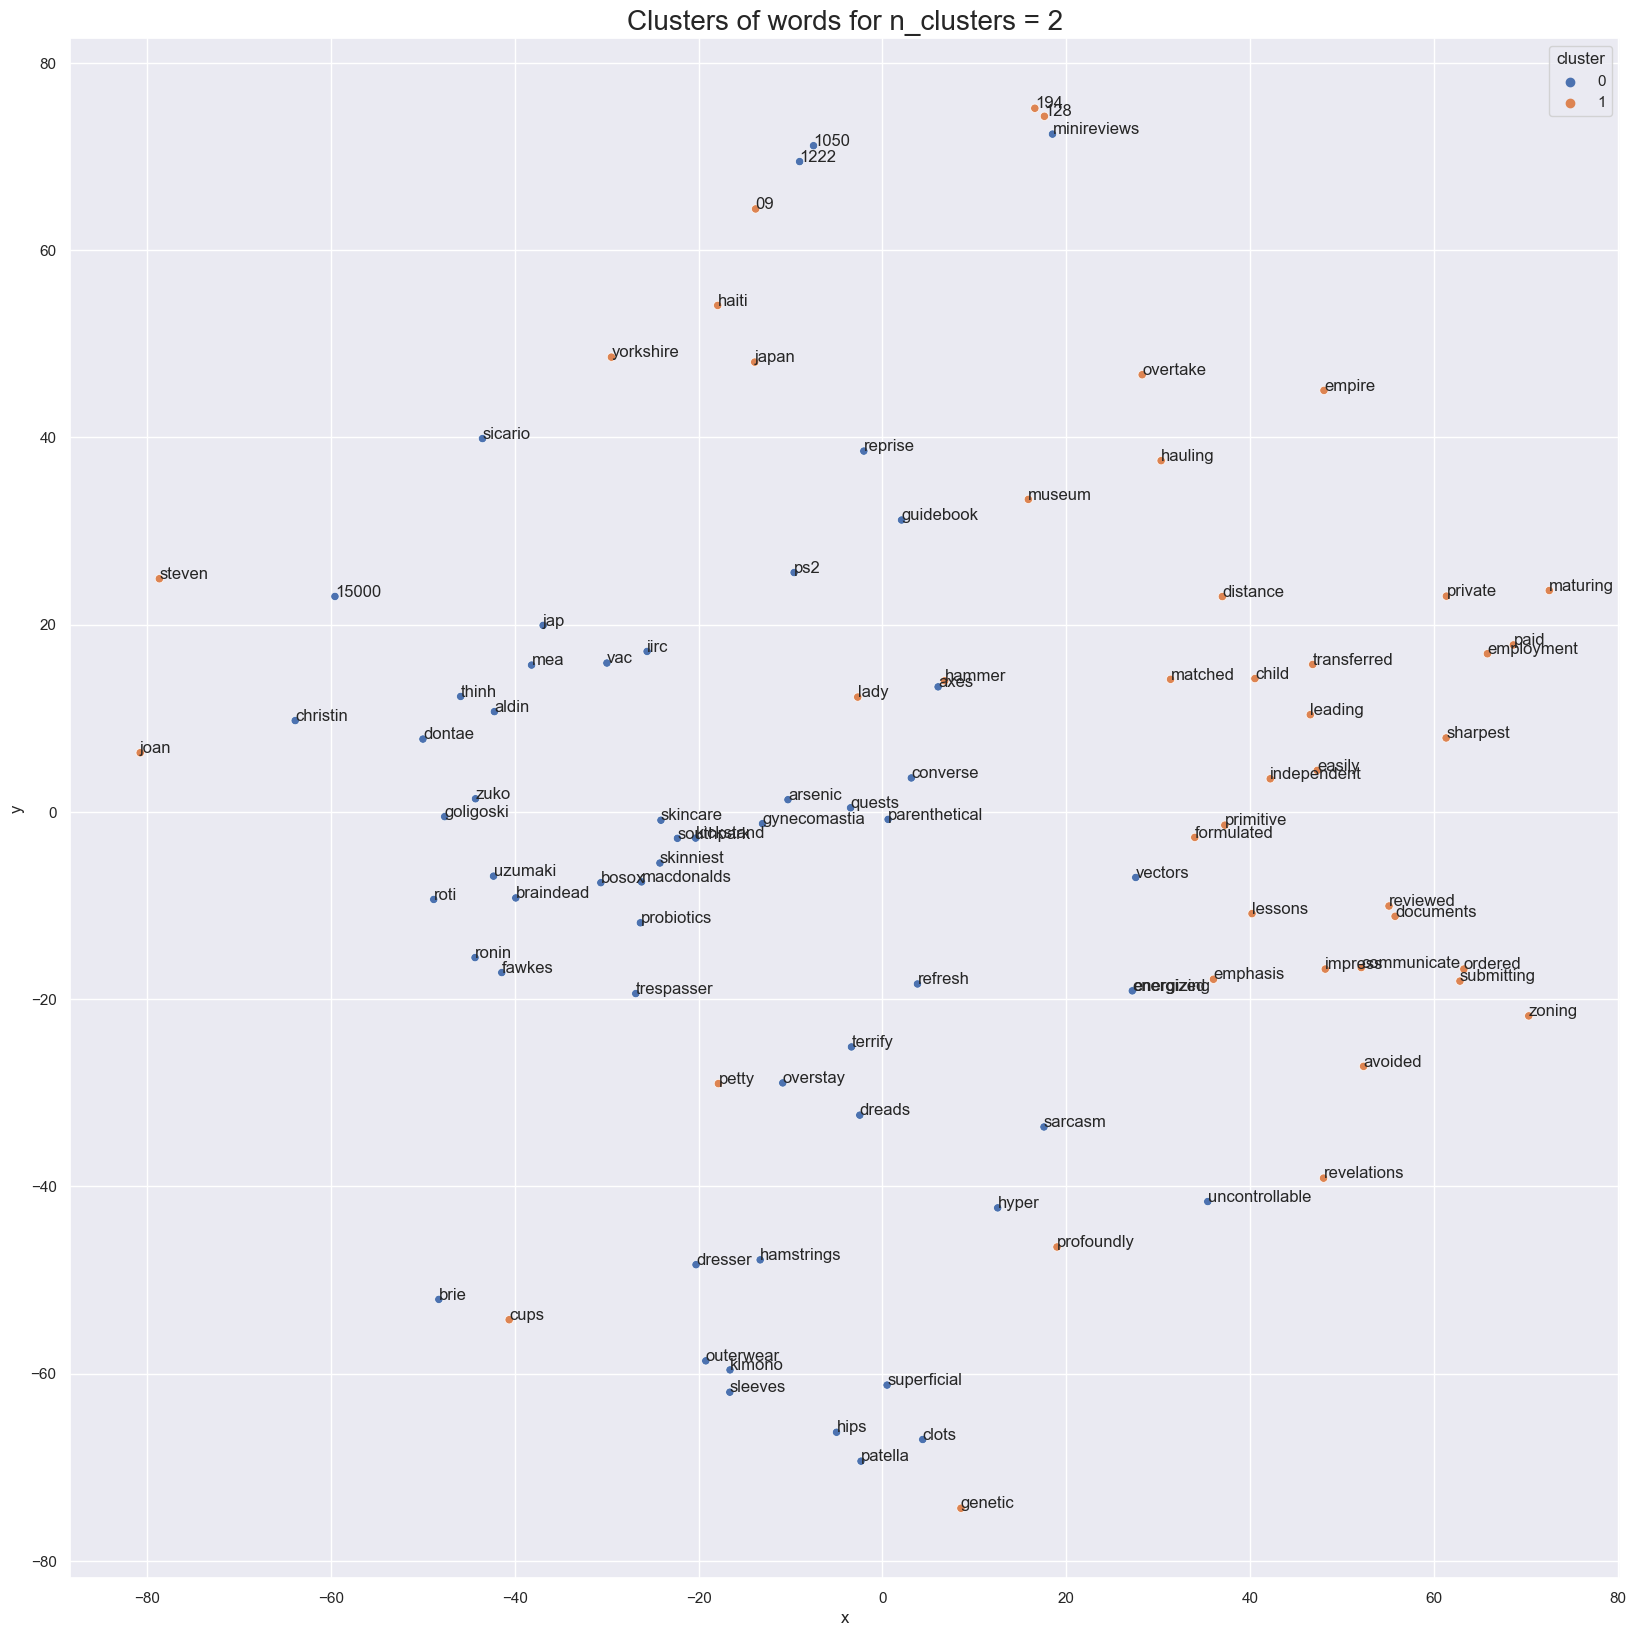

INFO: Assigning cluster to each word.
INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 3.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Visualising clusters.


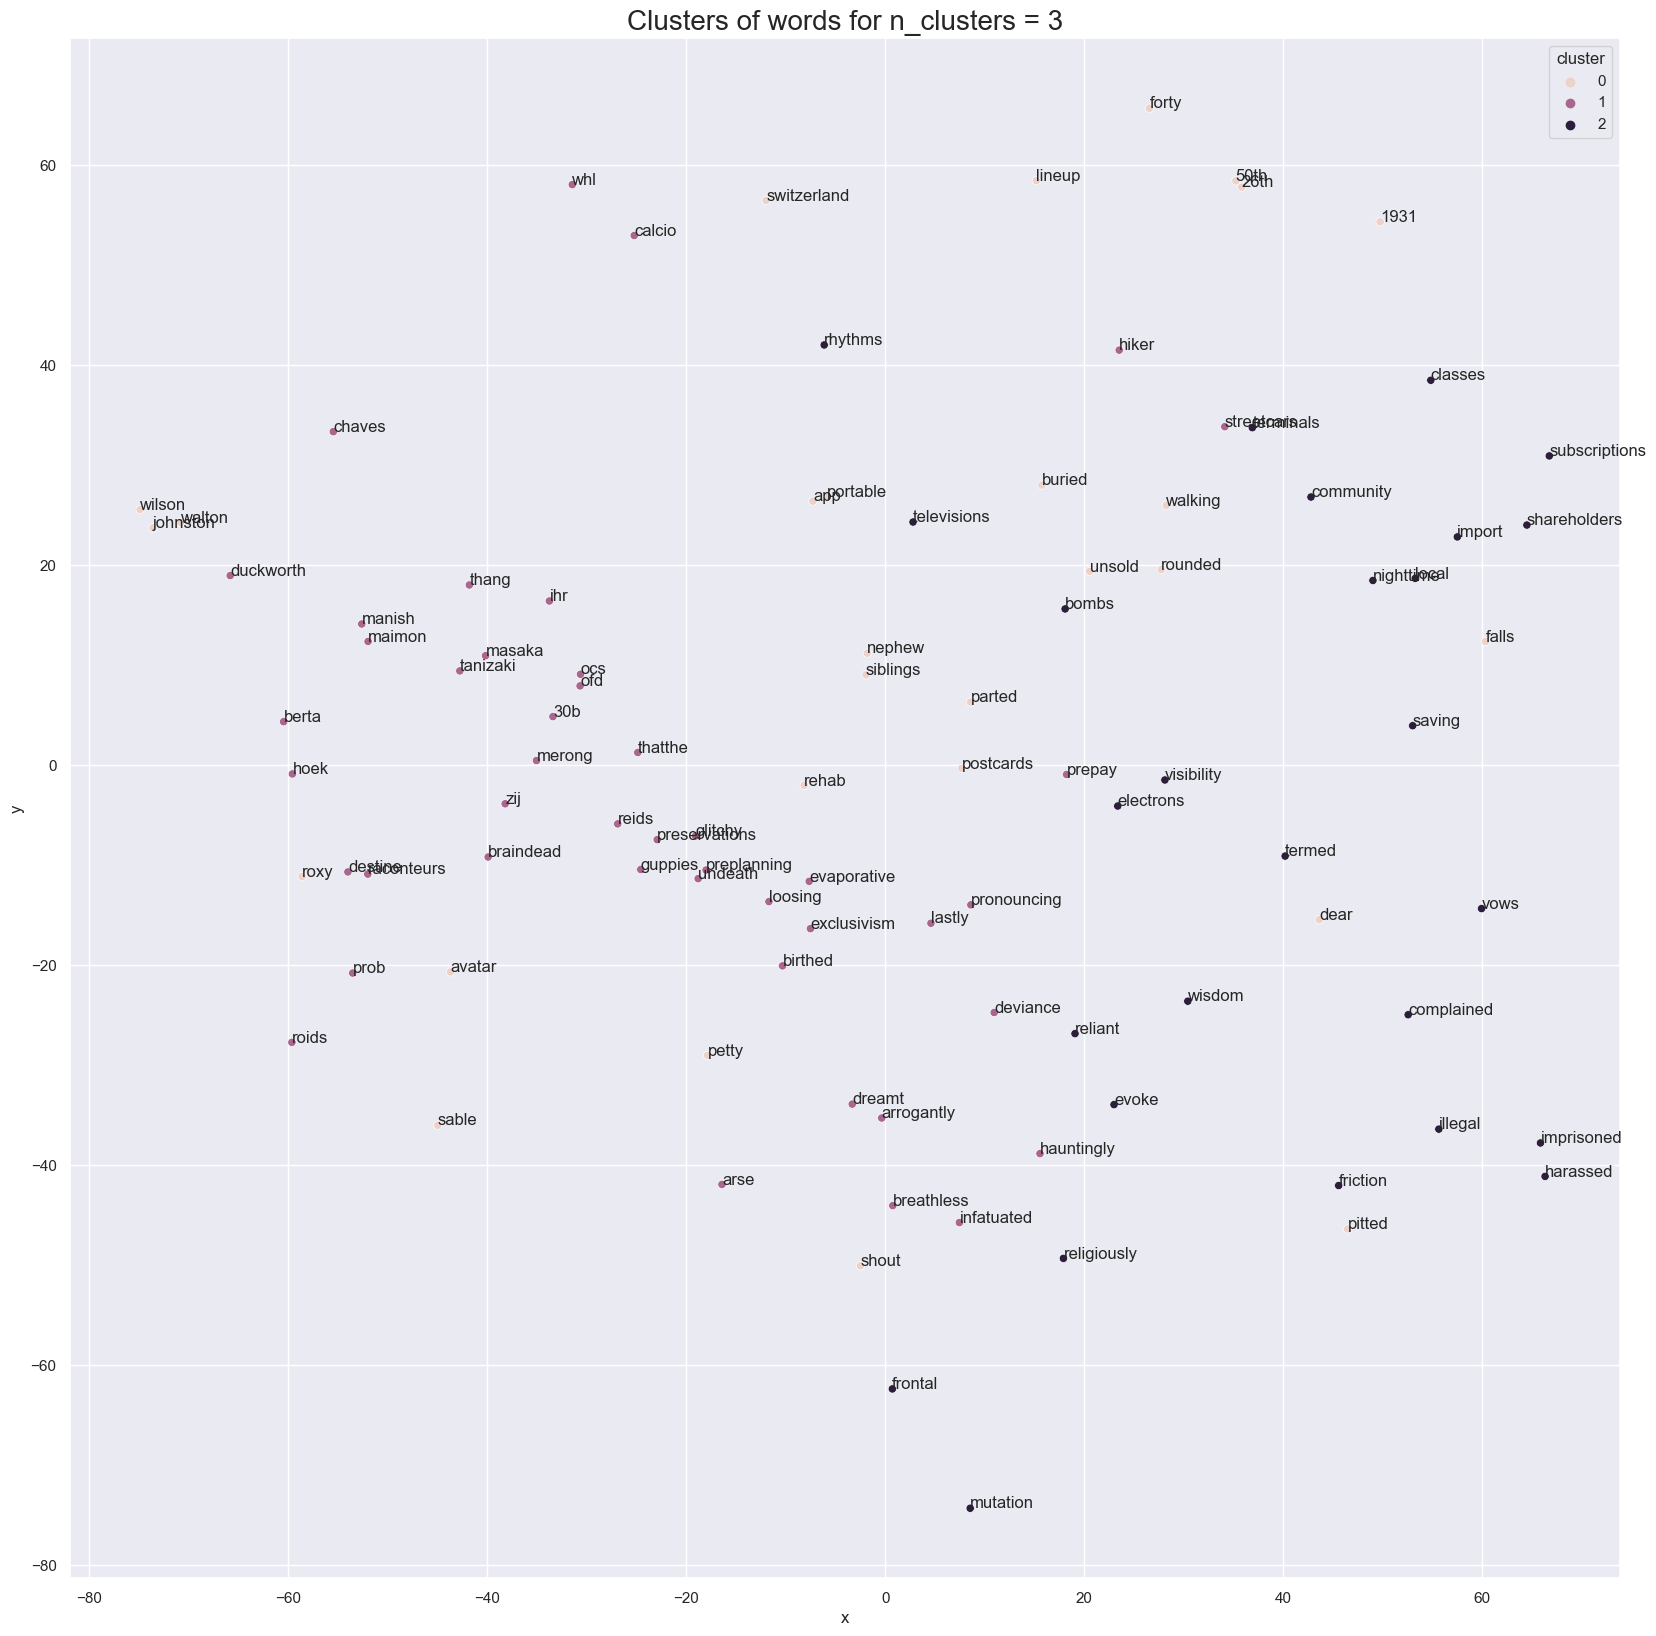

INFO: Assigning cluster to each word.
INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 4.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Visualising clusters.


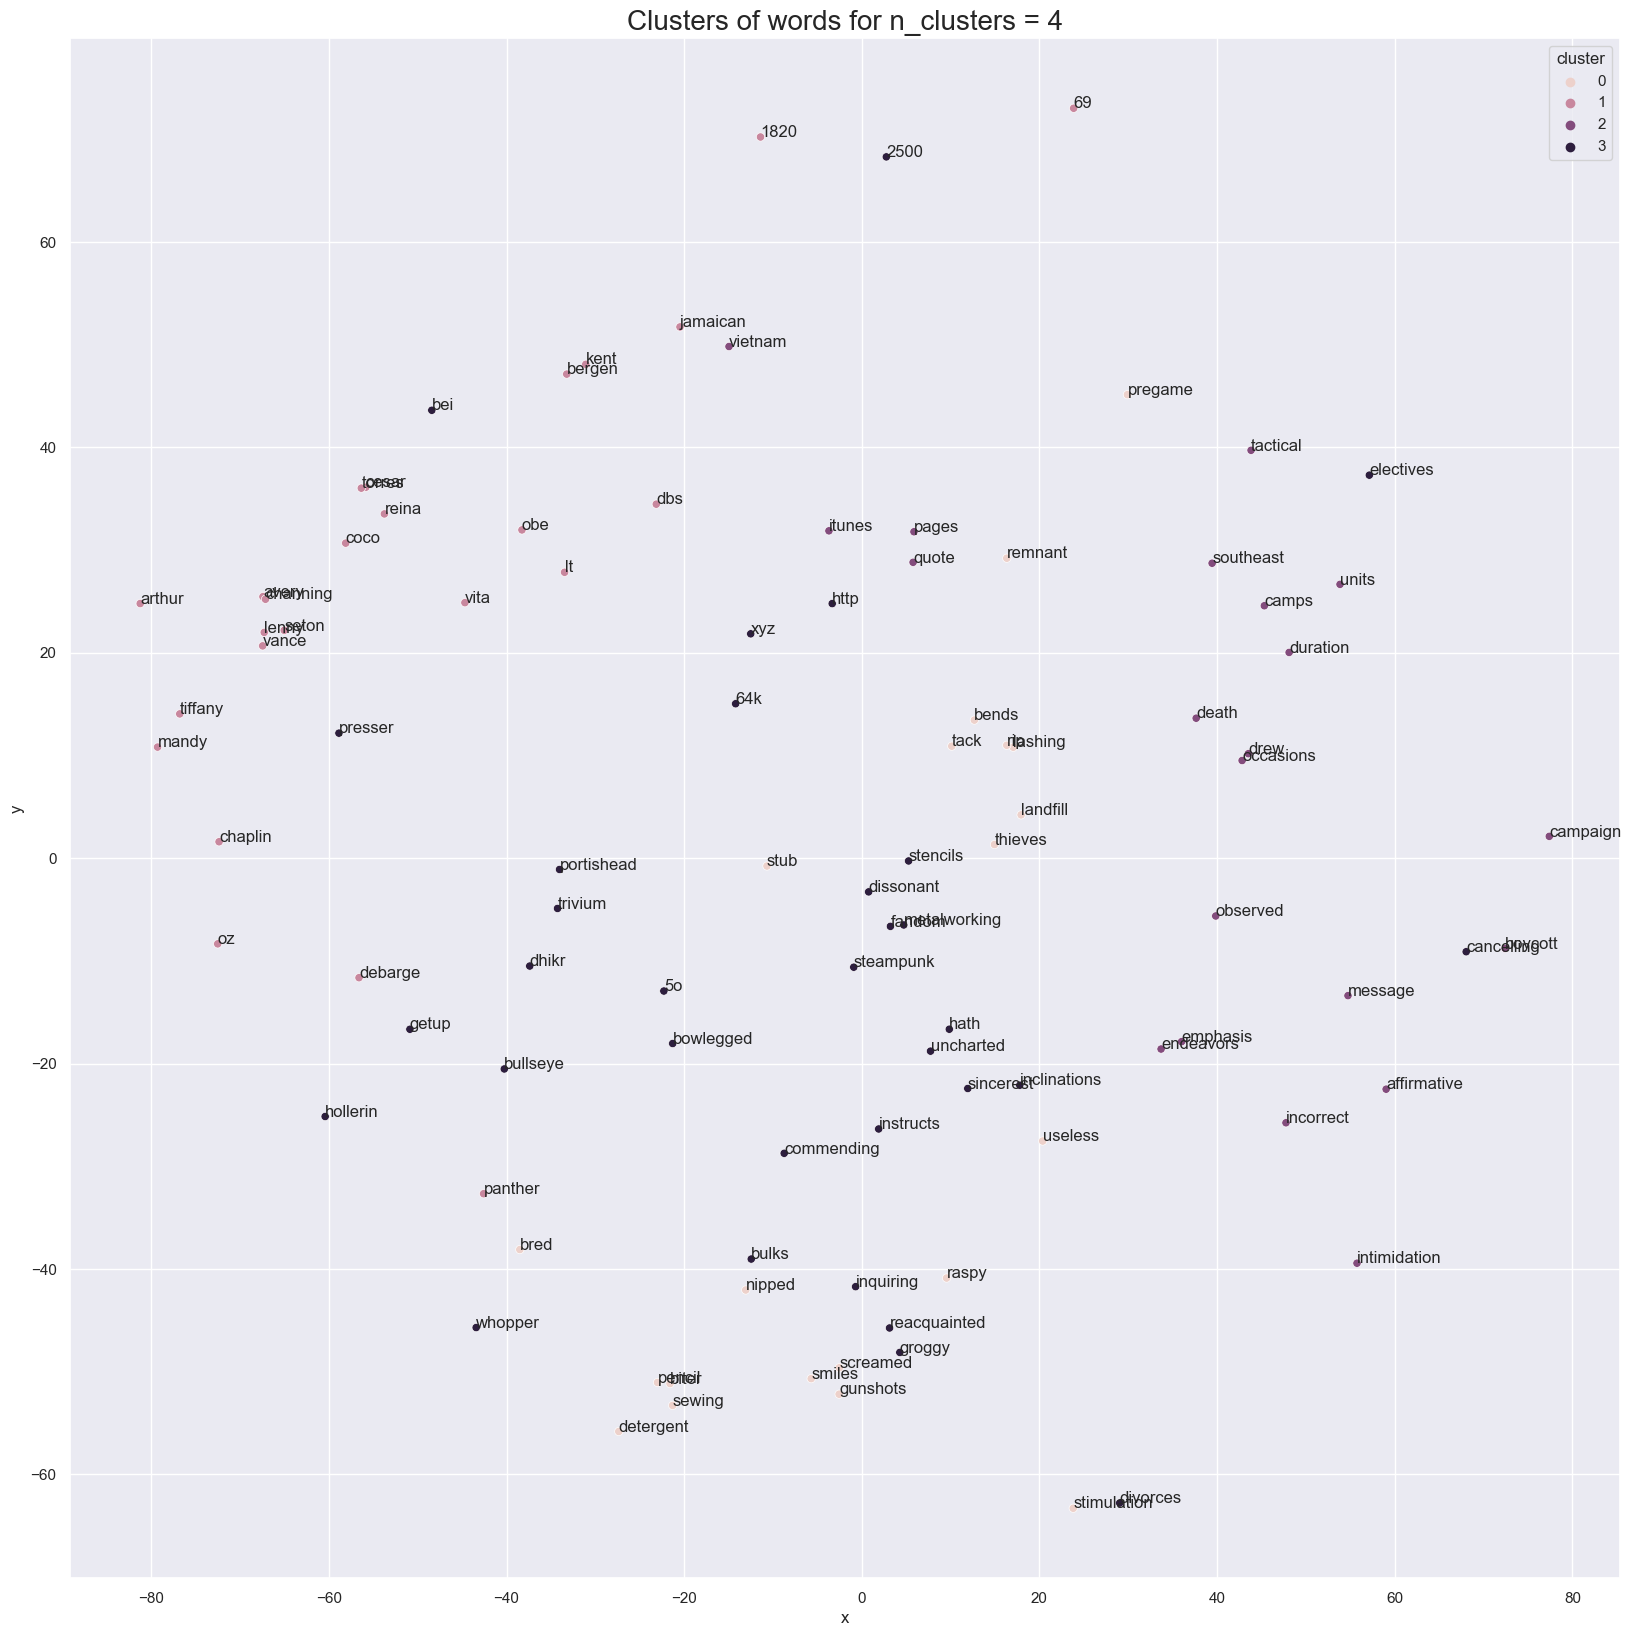

INFO: Assigning cluster to each word.
INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 5.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Visualising clusters.


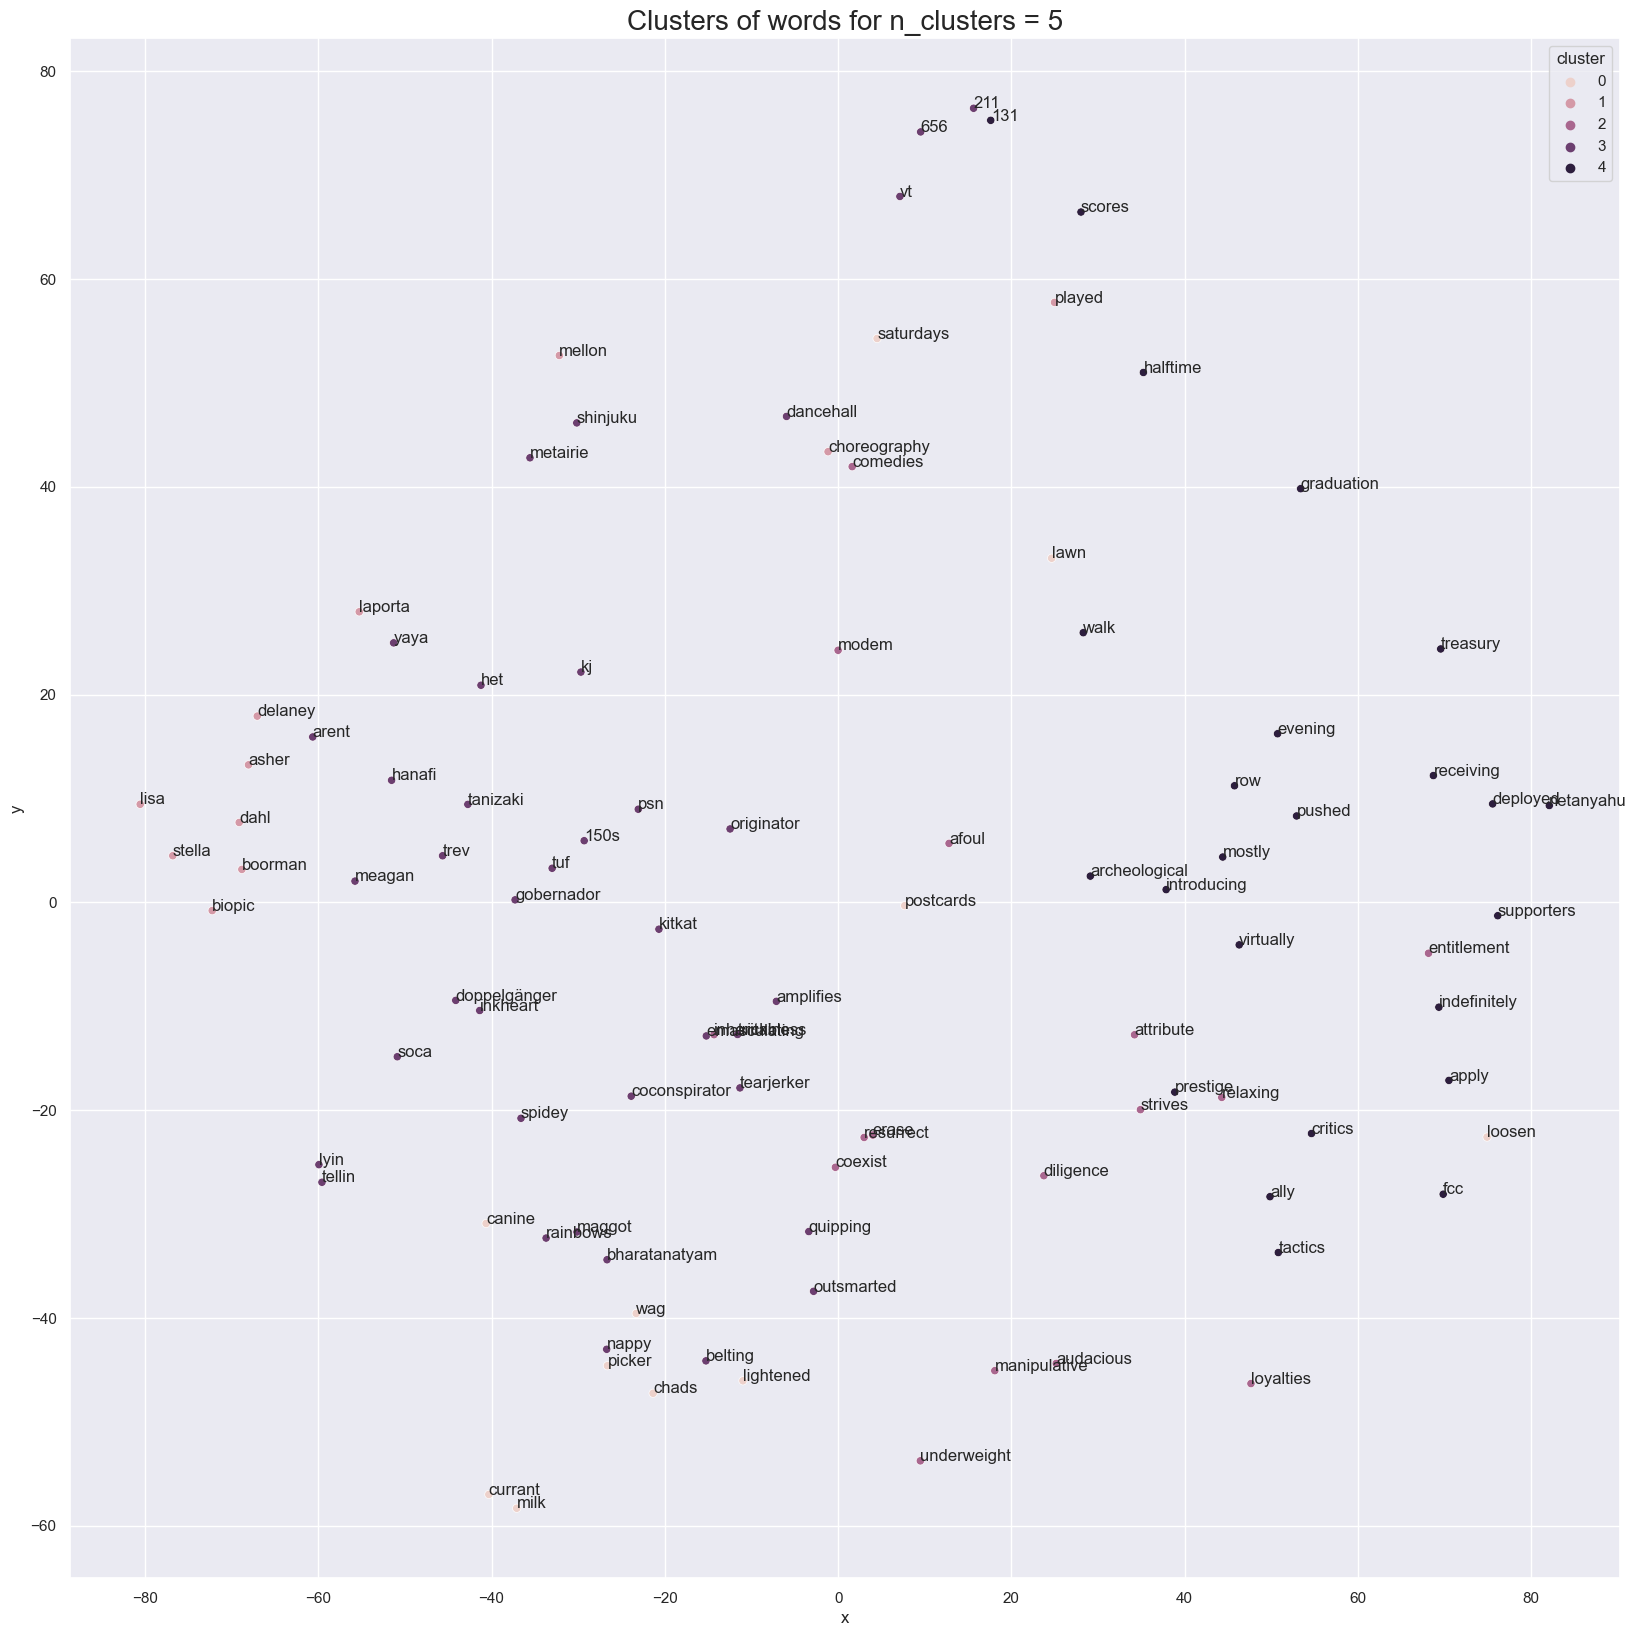

INFO: Assigning cluster to each word.
INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 6.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Visualising clusters.


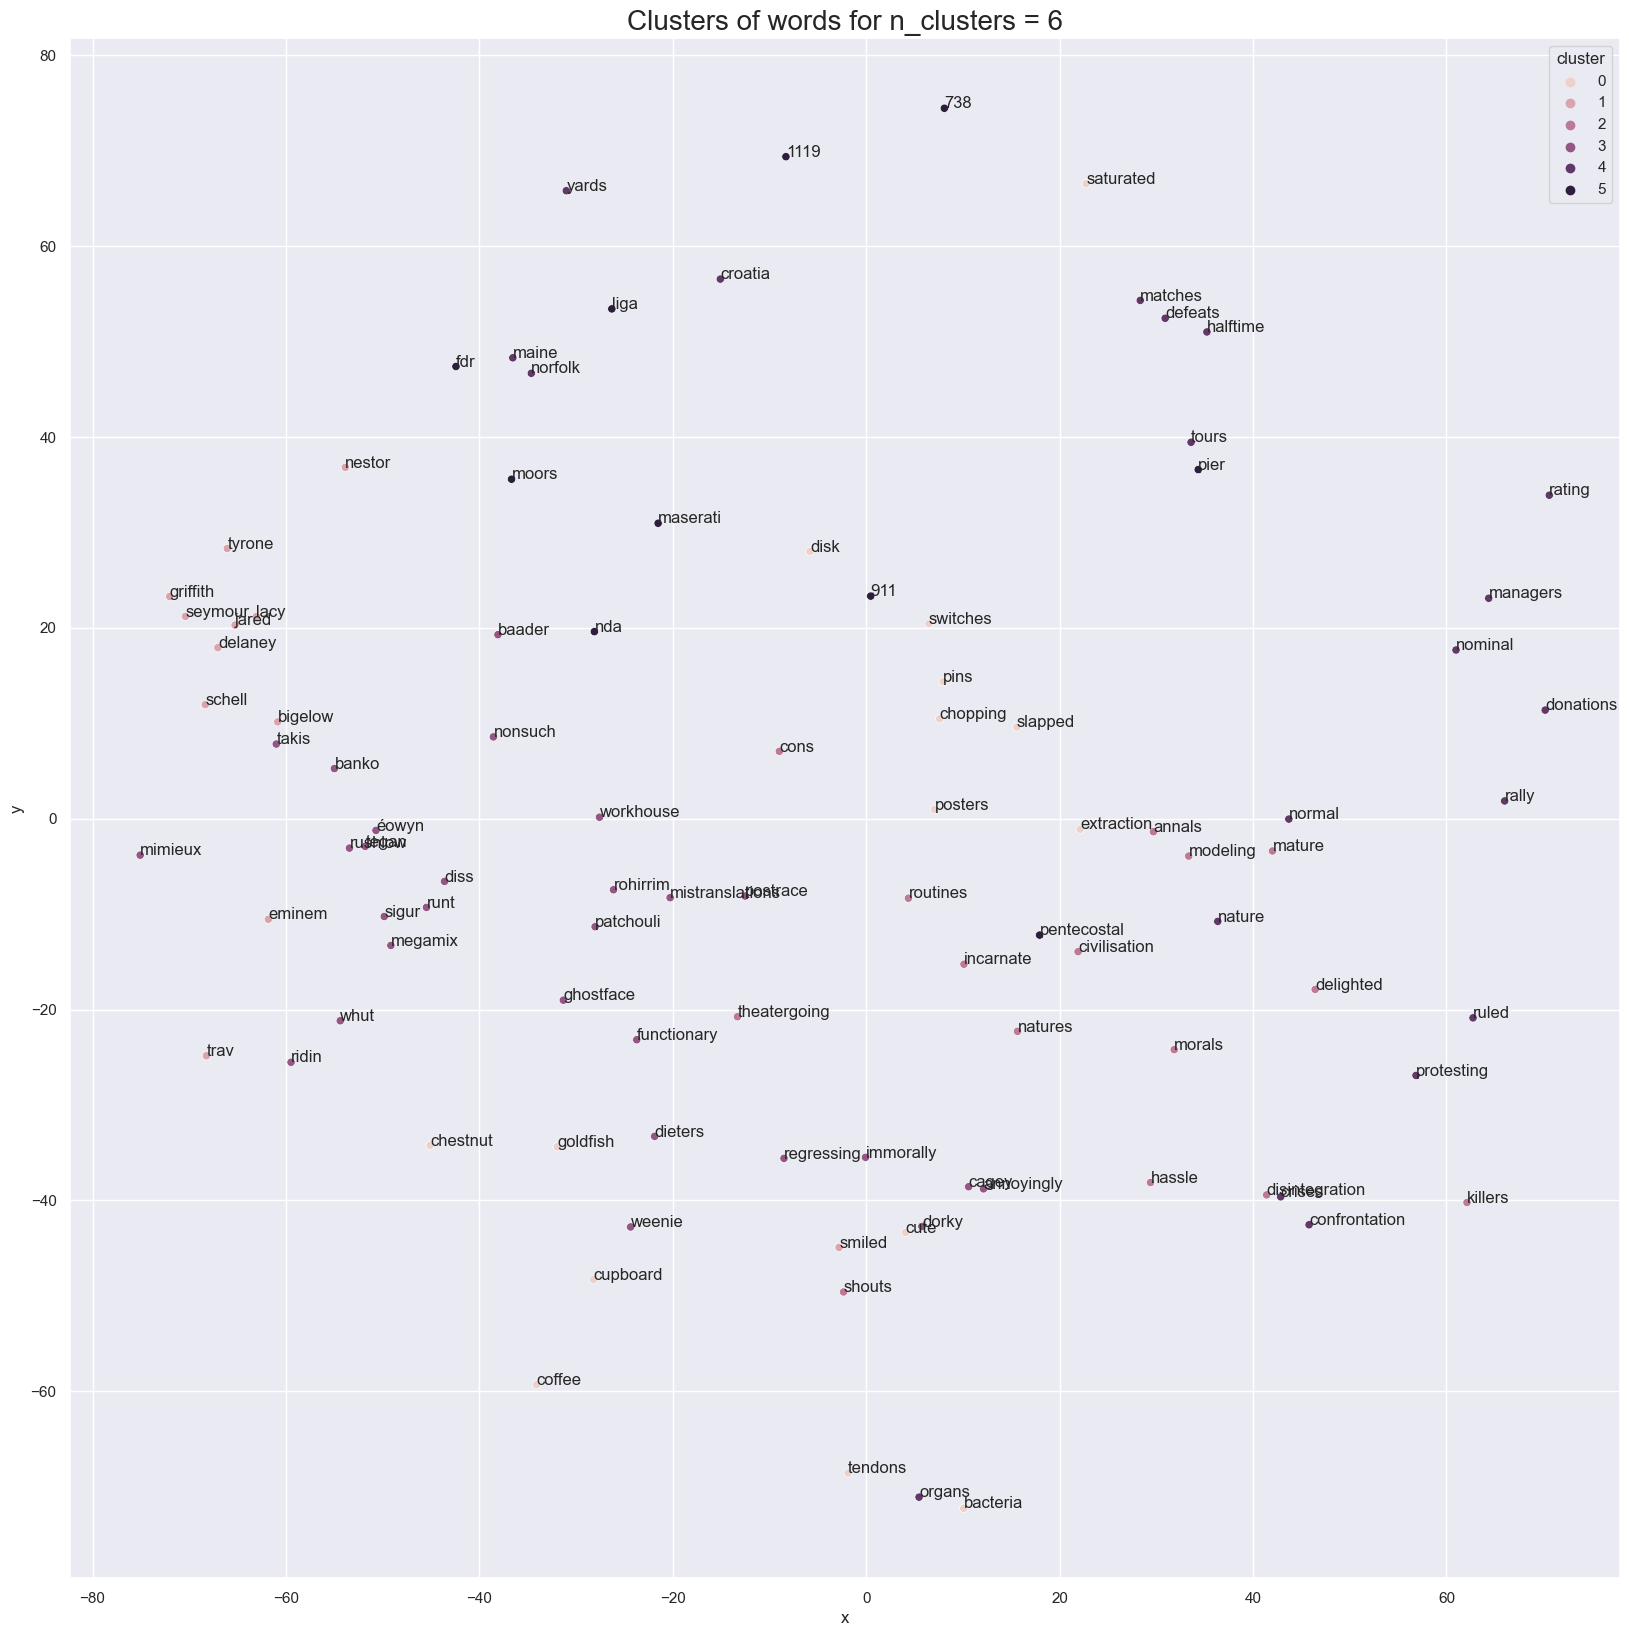

INFO: Assigning cluster to each word.
INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 7.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Visualising clusters.


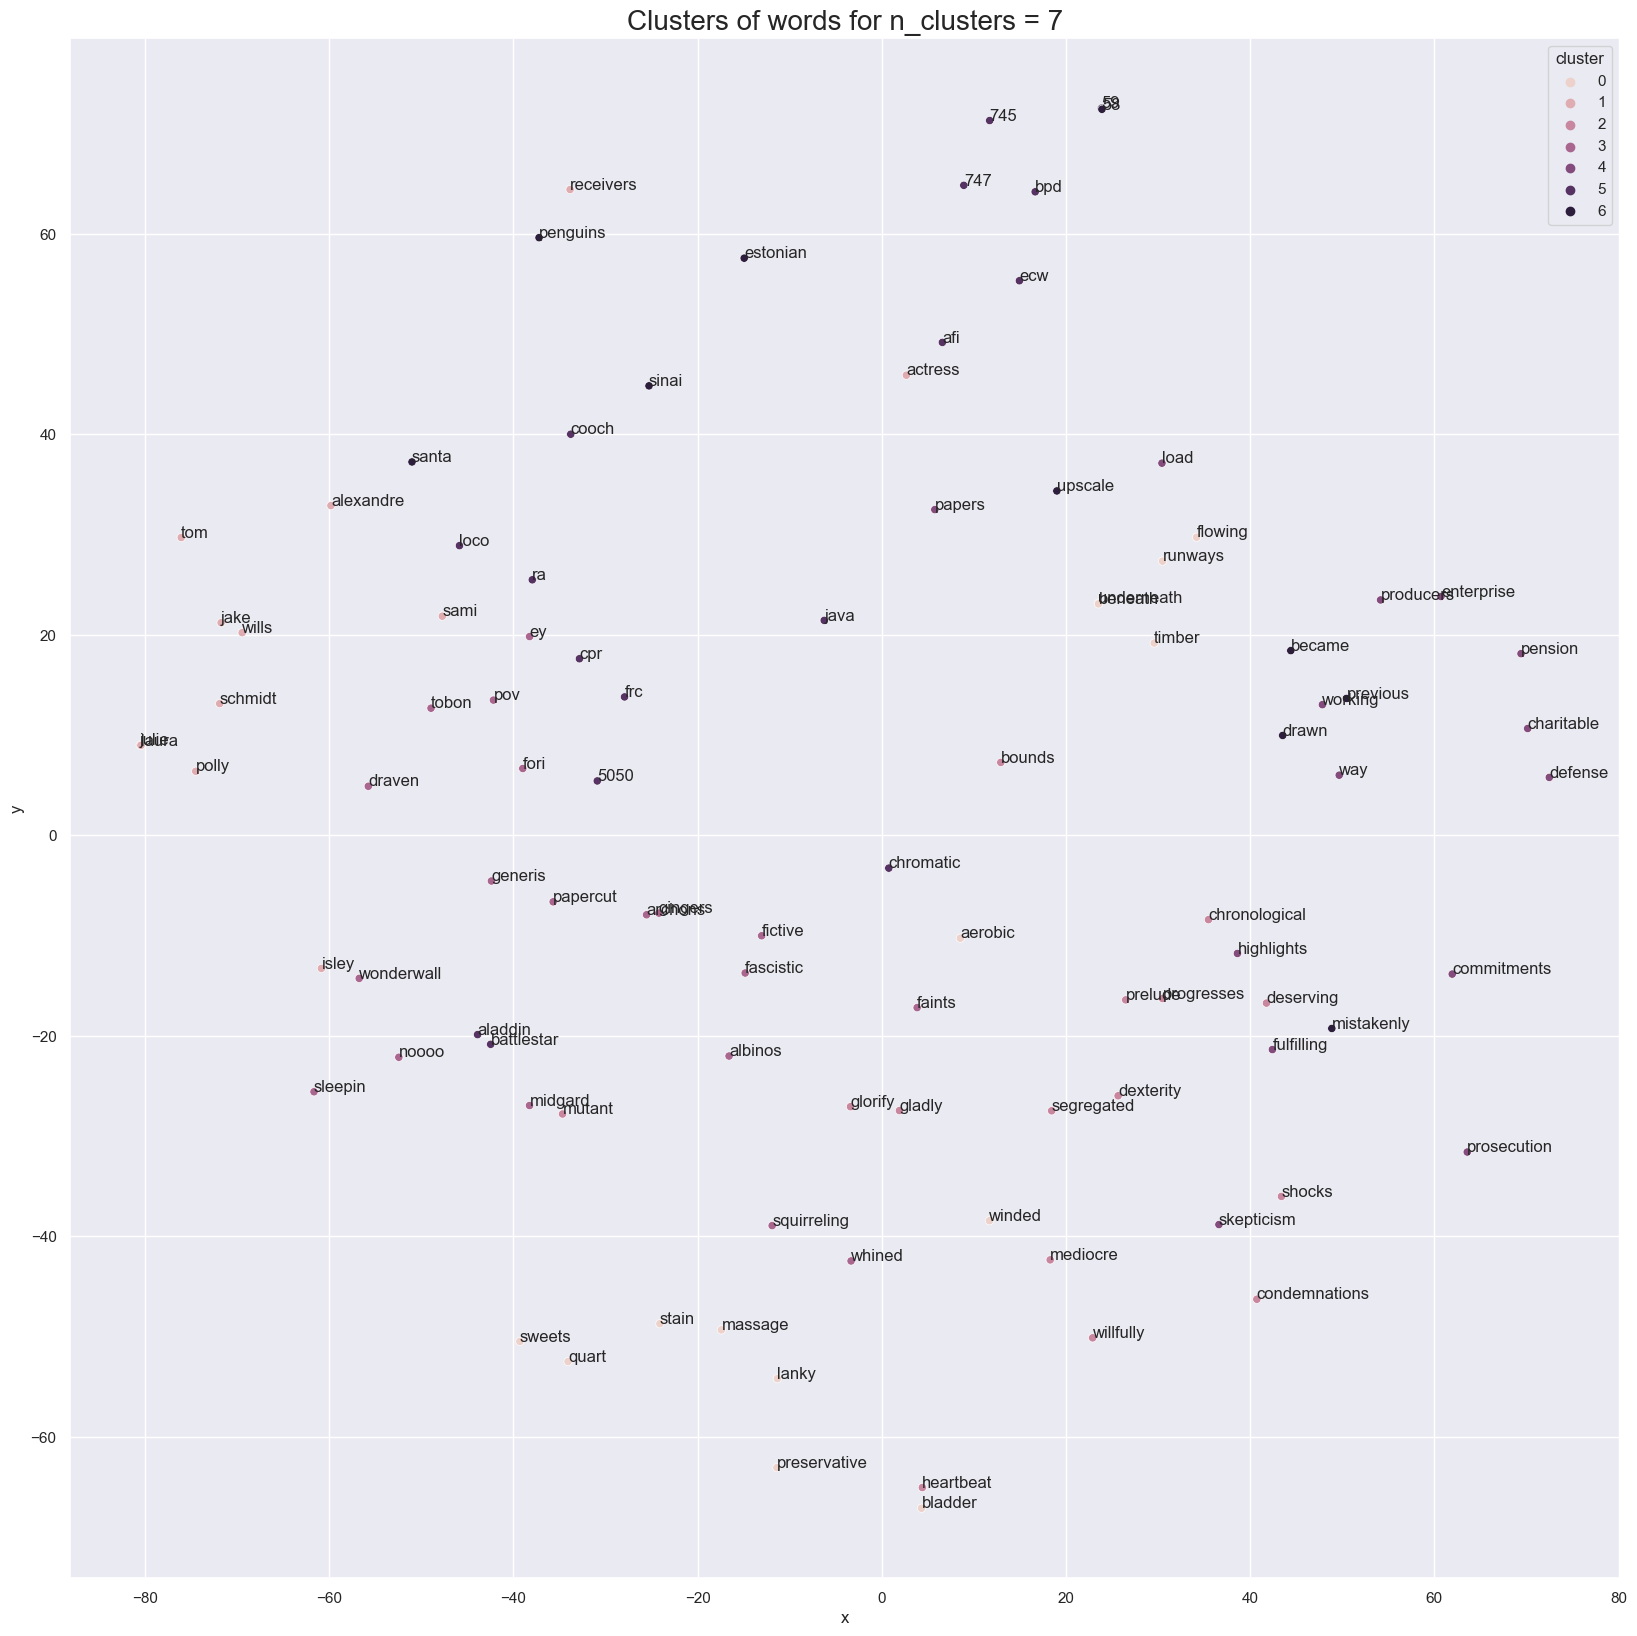

INFO: Assigning cluster to each word.
INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 8.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Visualising clusters.


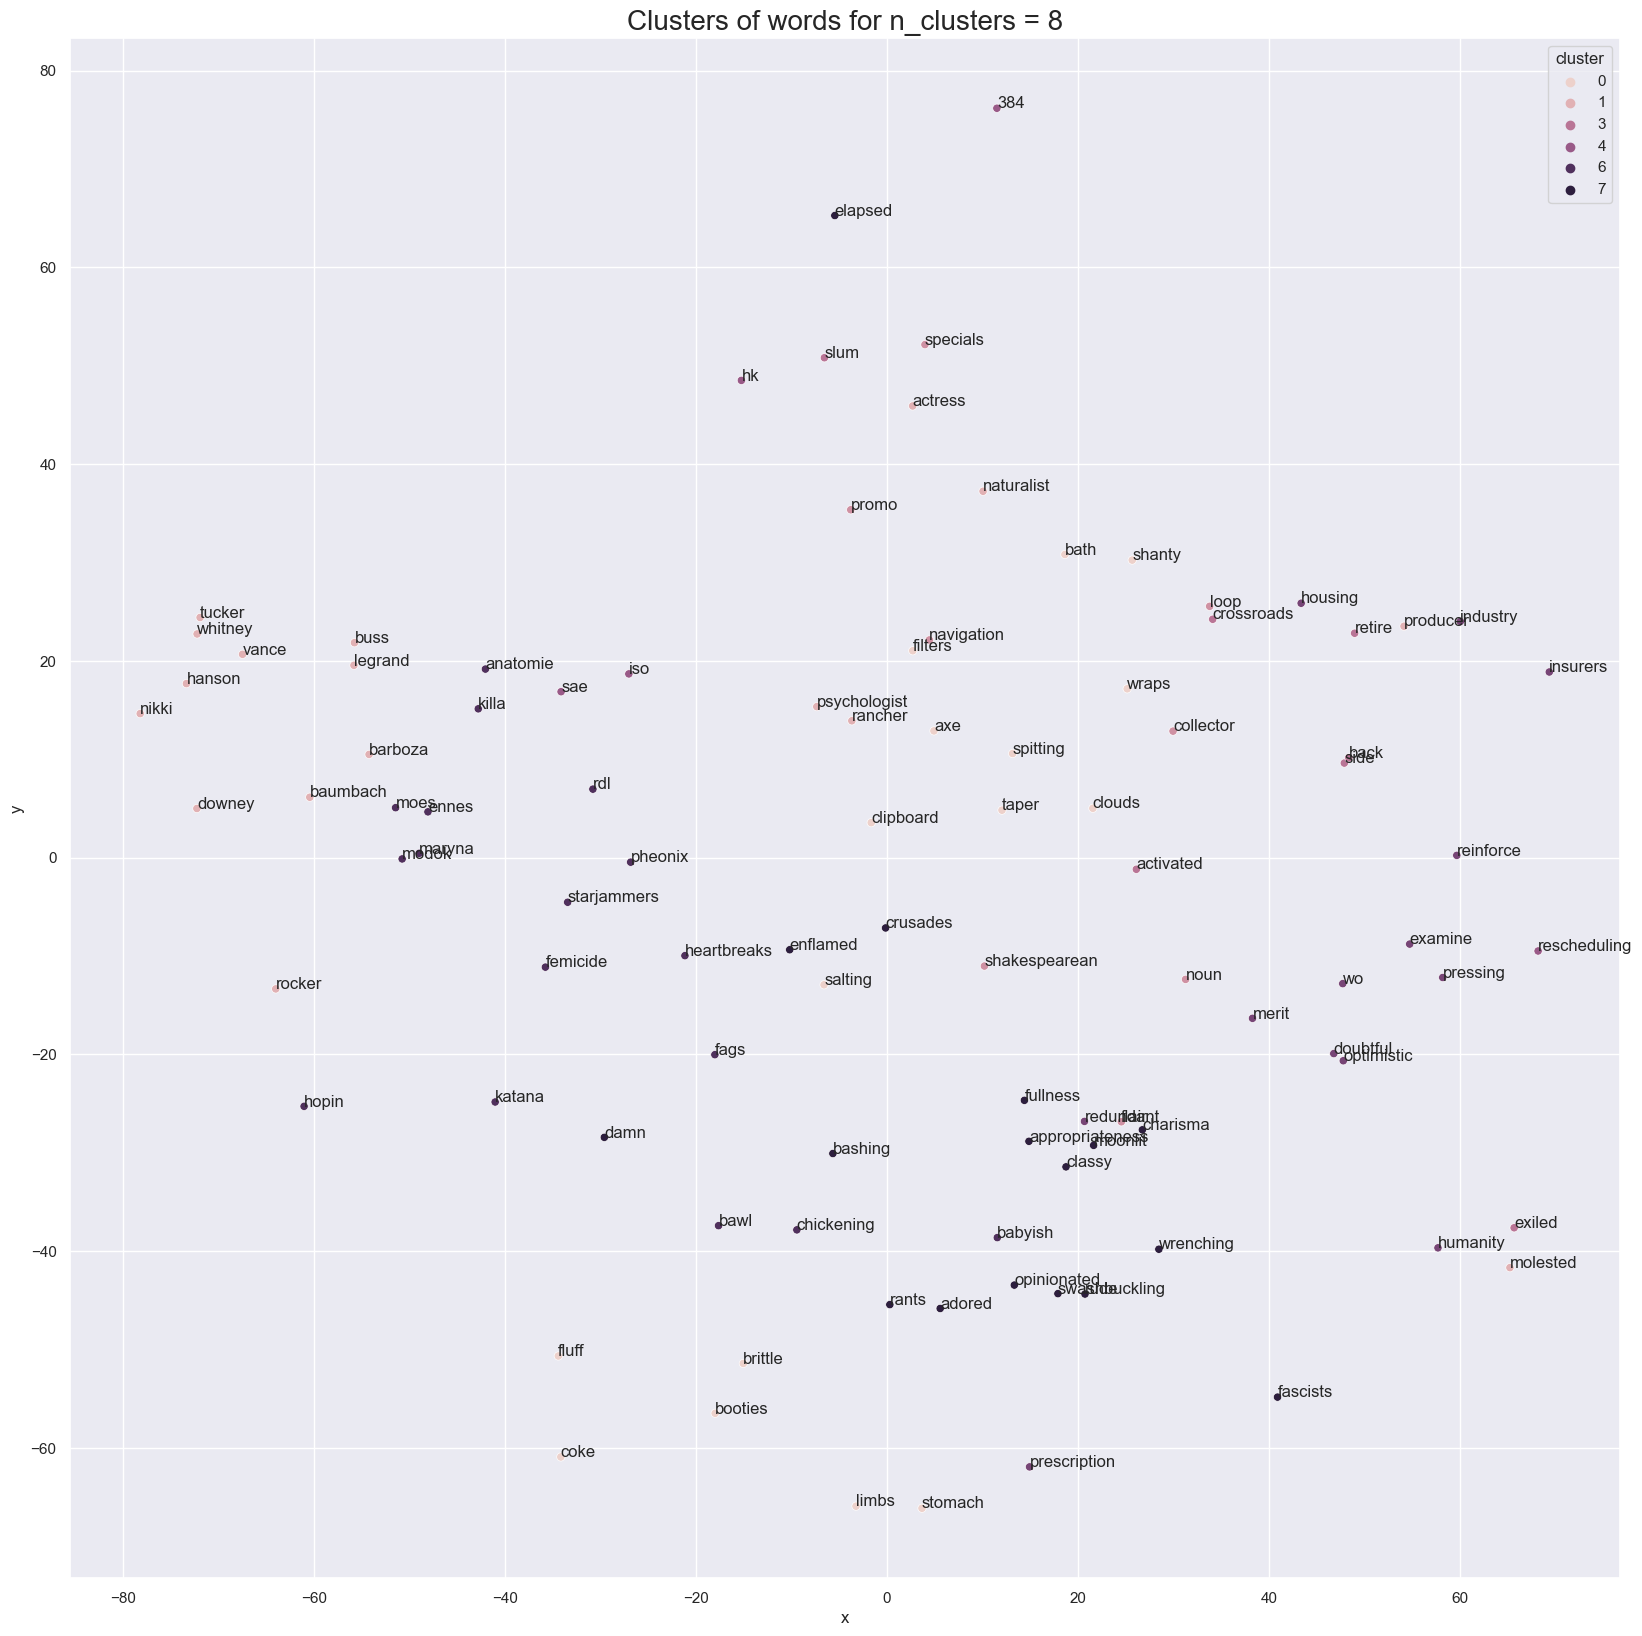

INFO: Assigning cluster to each word.
INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 9.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Visualising clusters.


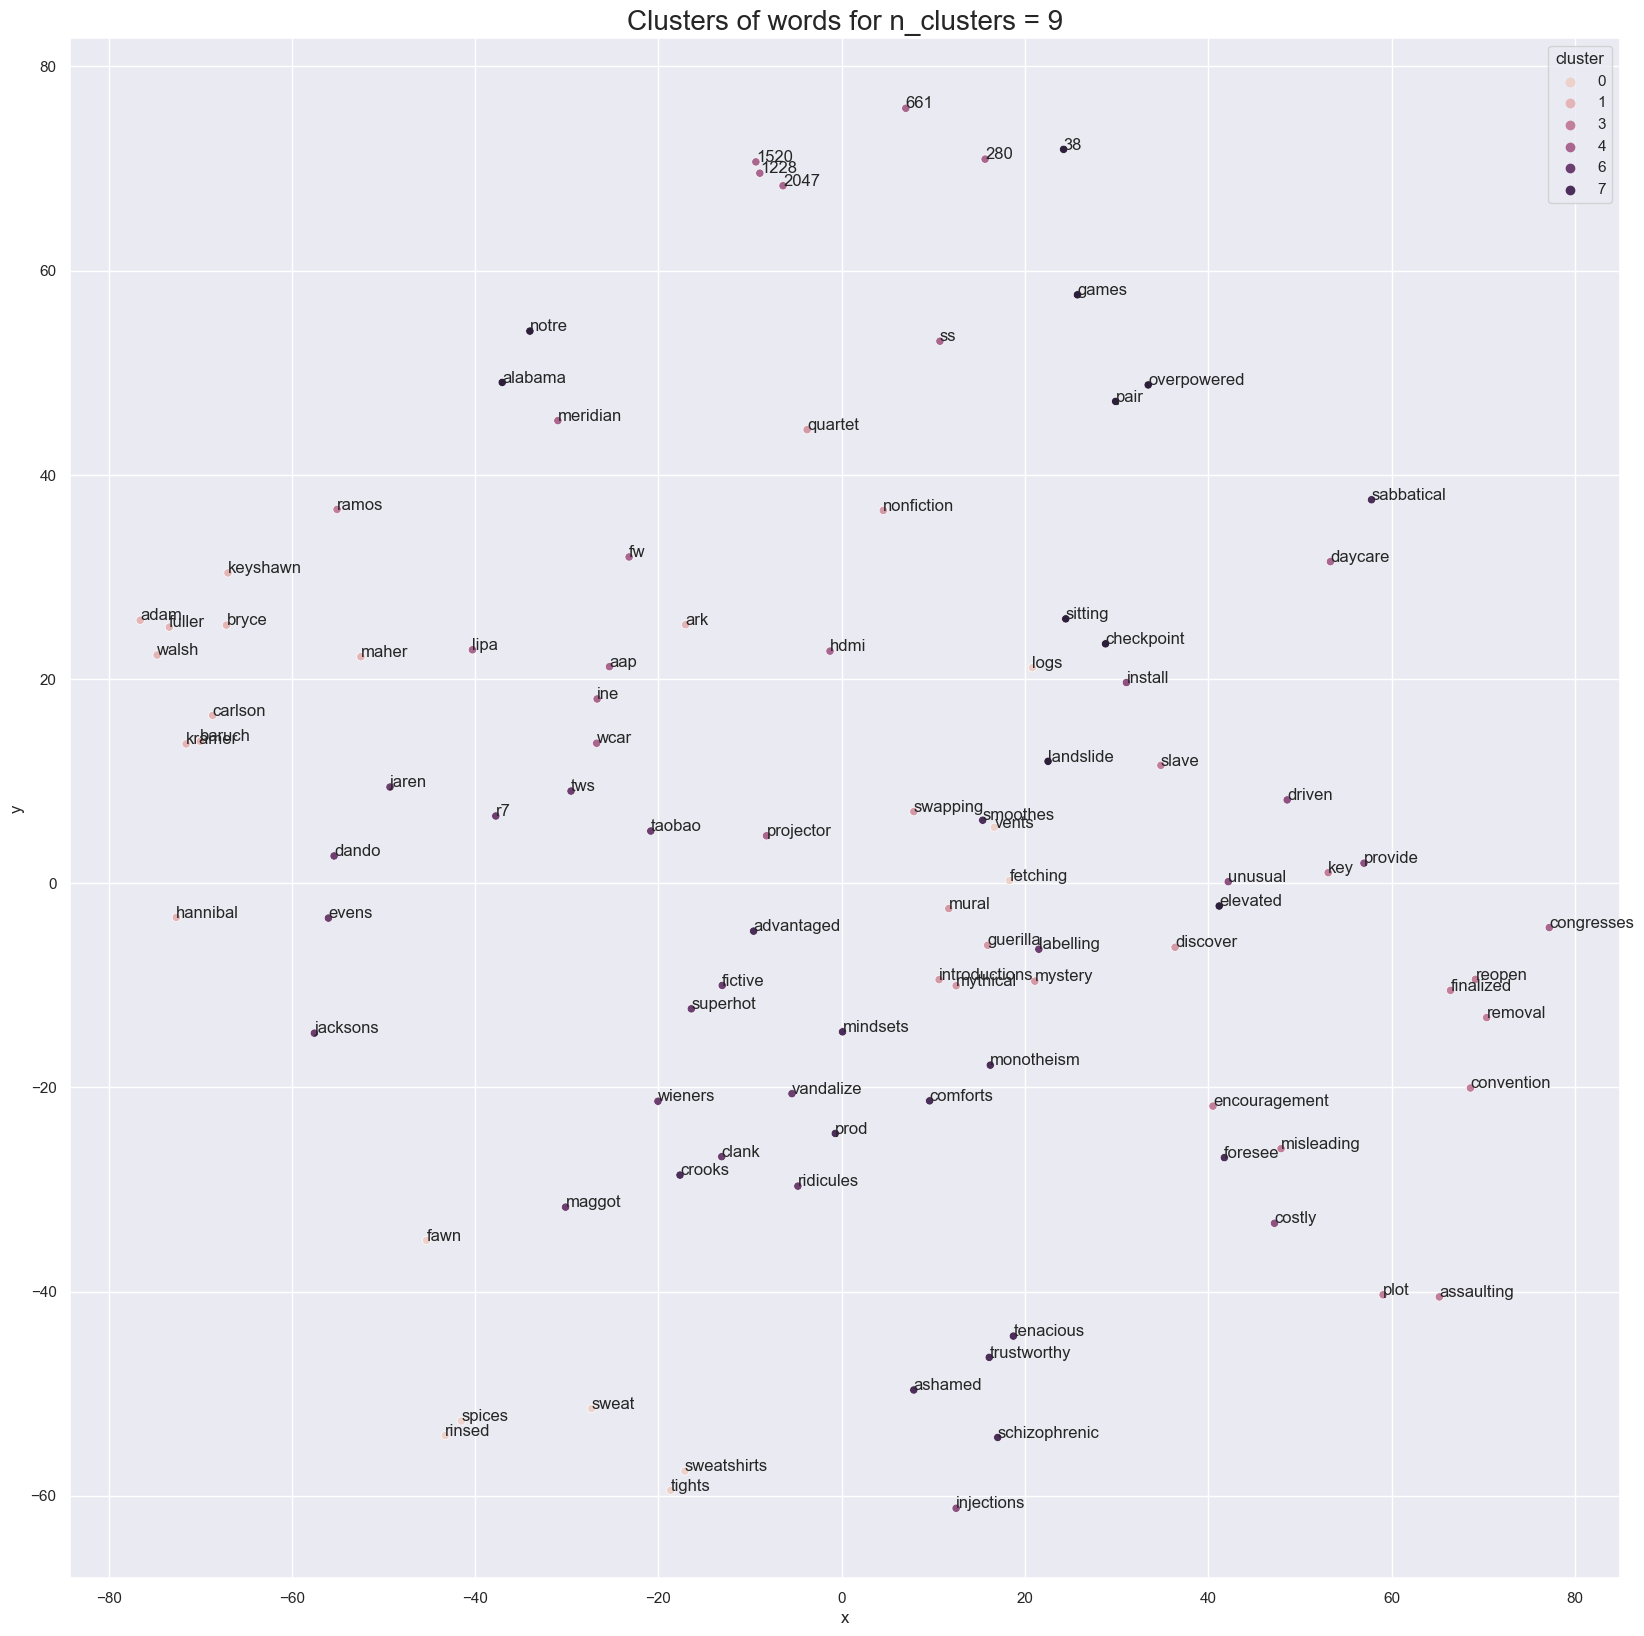

INFO: Assigning cluster to each word.
INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 10.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Visualising clusters.


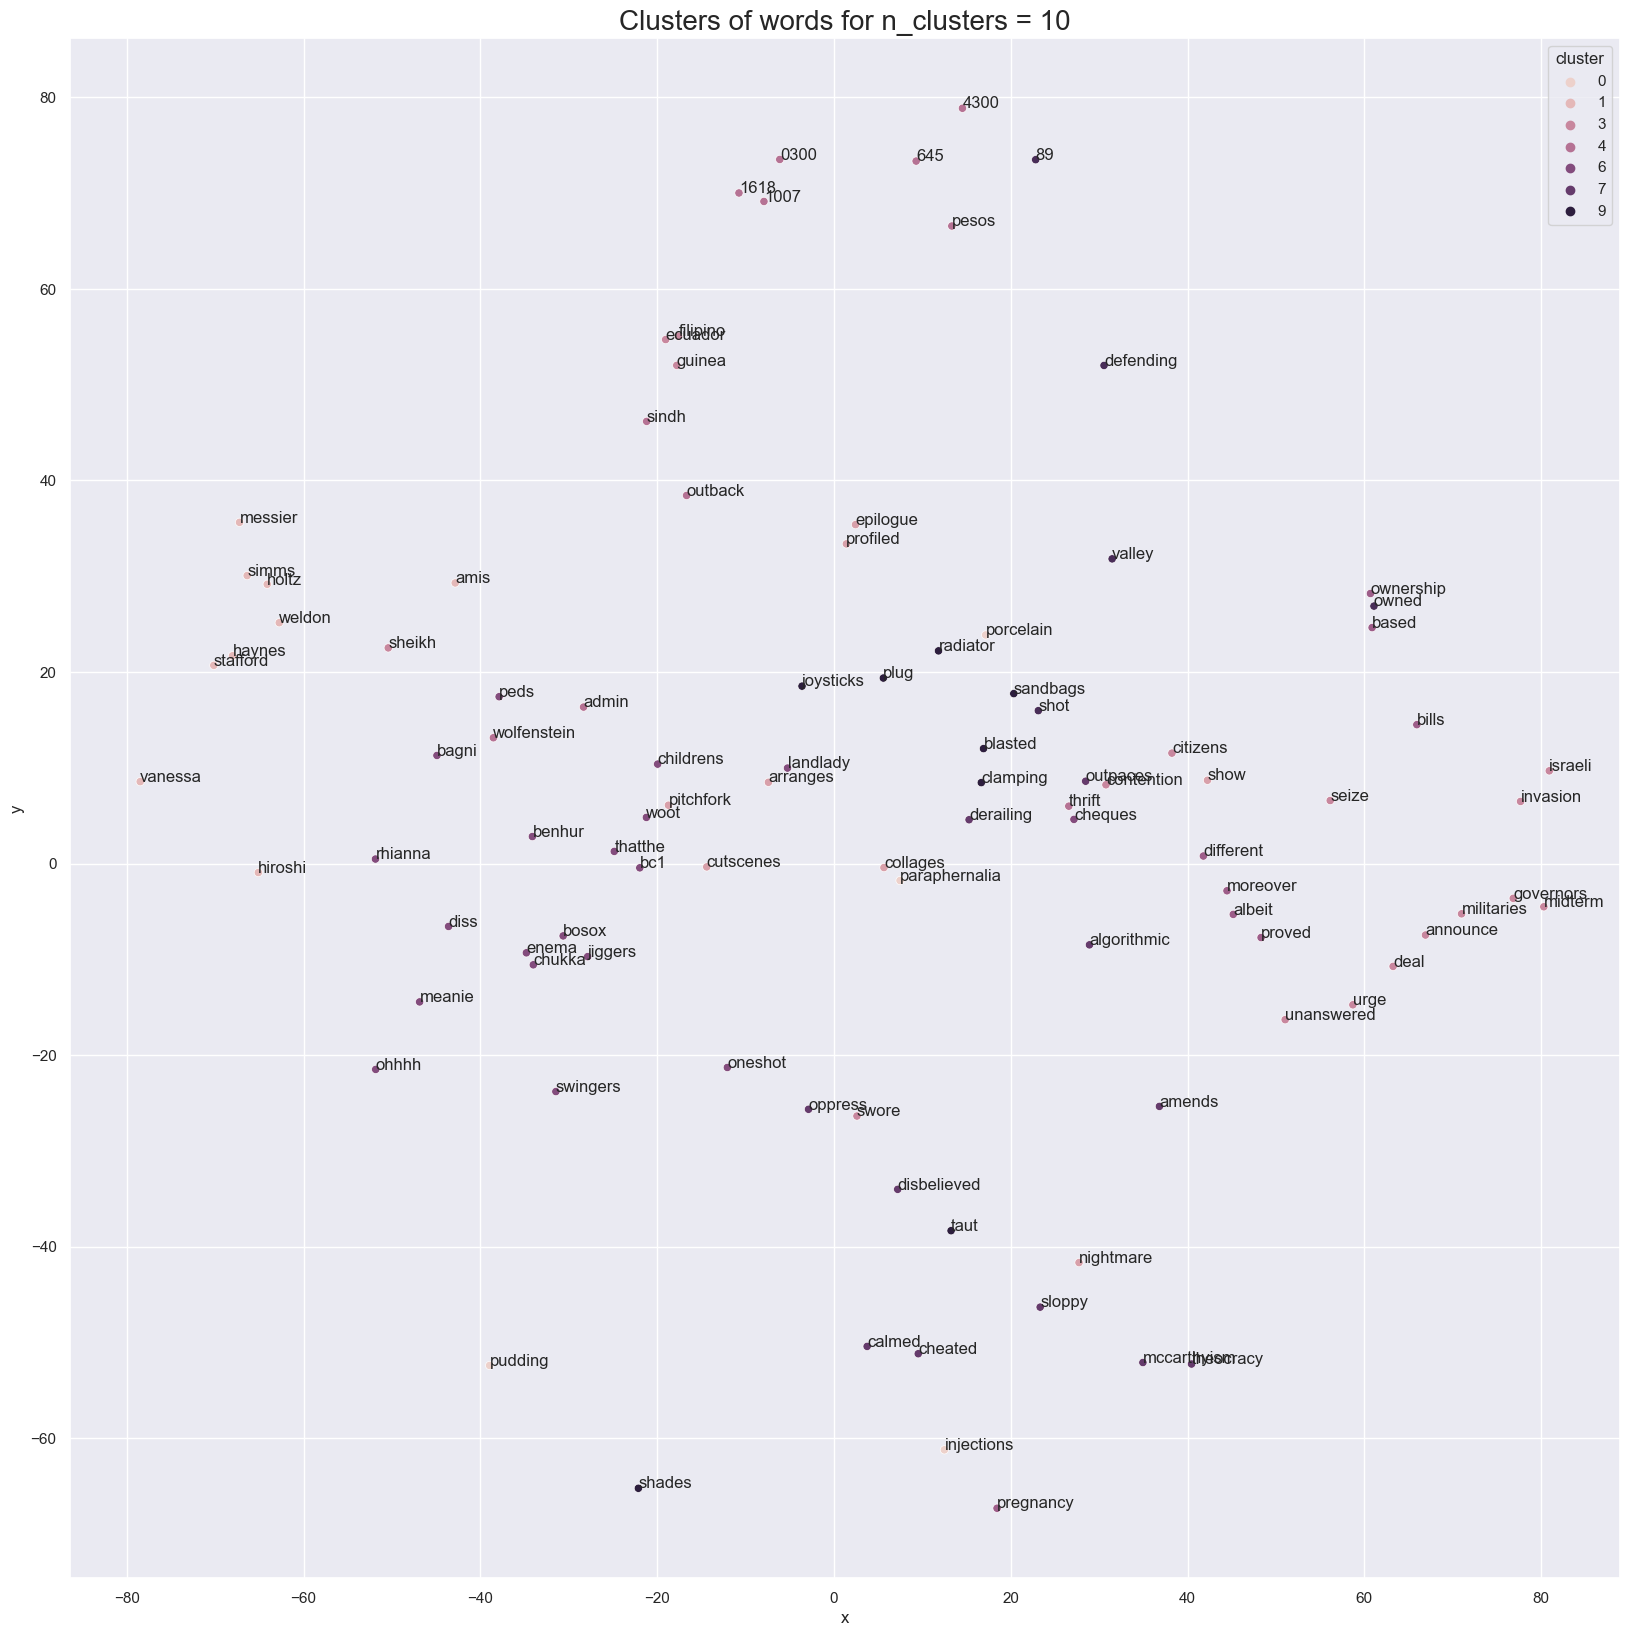

INFO: Assigning cluster to each word.


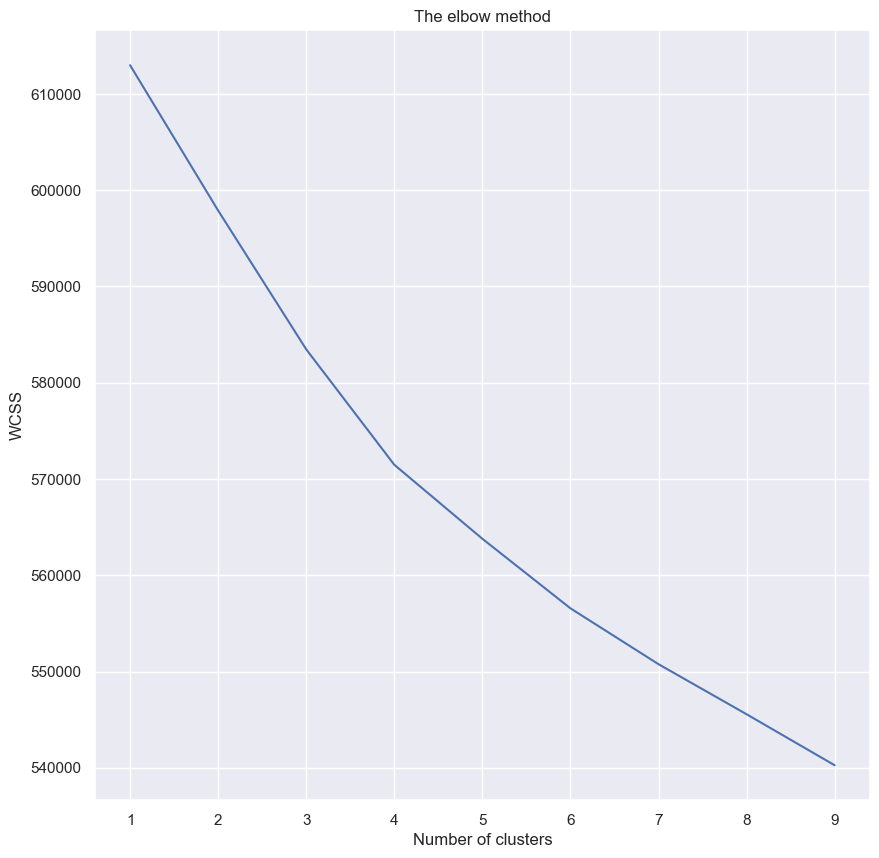

In [47]:
elbow_method(df, max_clusters=10)

INFO: glove-wiki-gigaword-50 loaded.
INFO: Transforming text to vector.
INFO: Clustering vectors using k-means for n_clusters = 4.
INFO: Calculating within cluster sum of squares.
INFO: Transforming vectors to 2D space for visualisation.
INFO: Creating dataframe for visualisation.
INFO: Sampling 100 points for visualisation.
INFO: Visualising clusters.


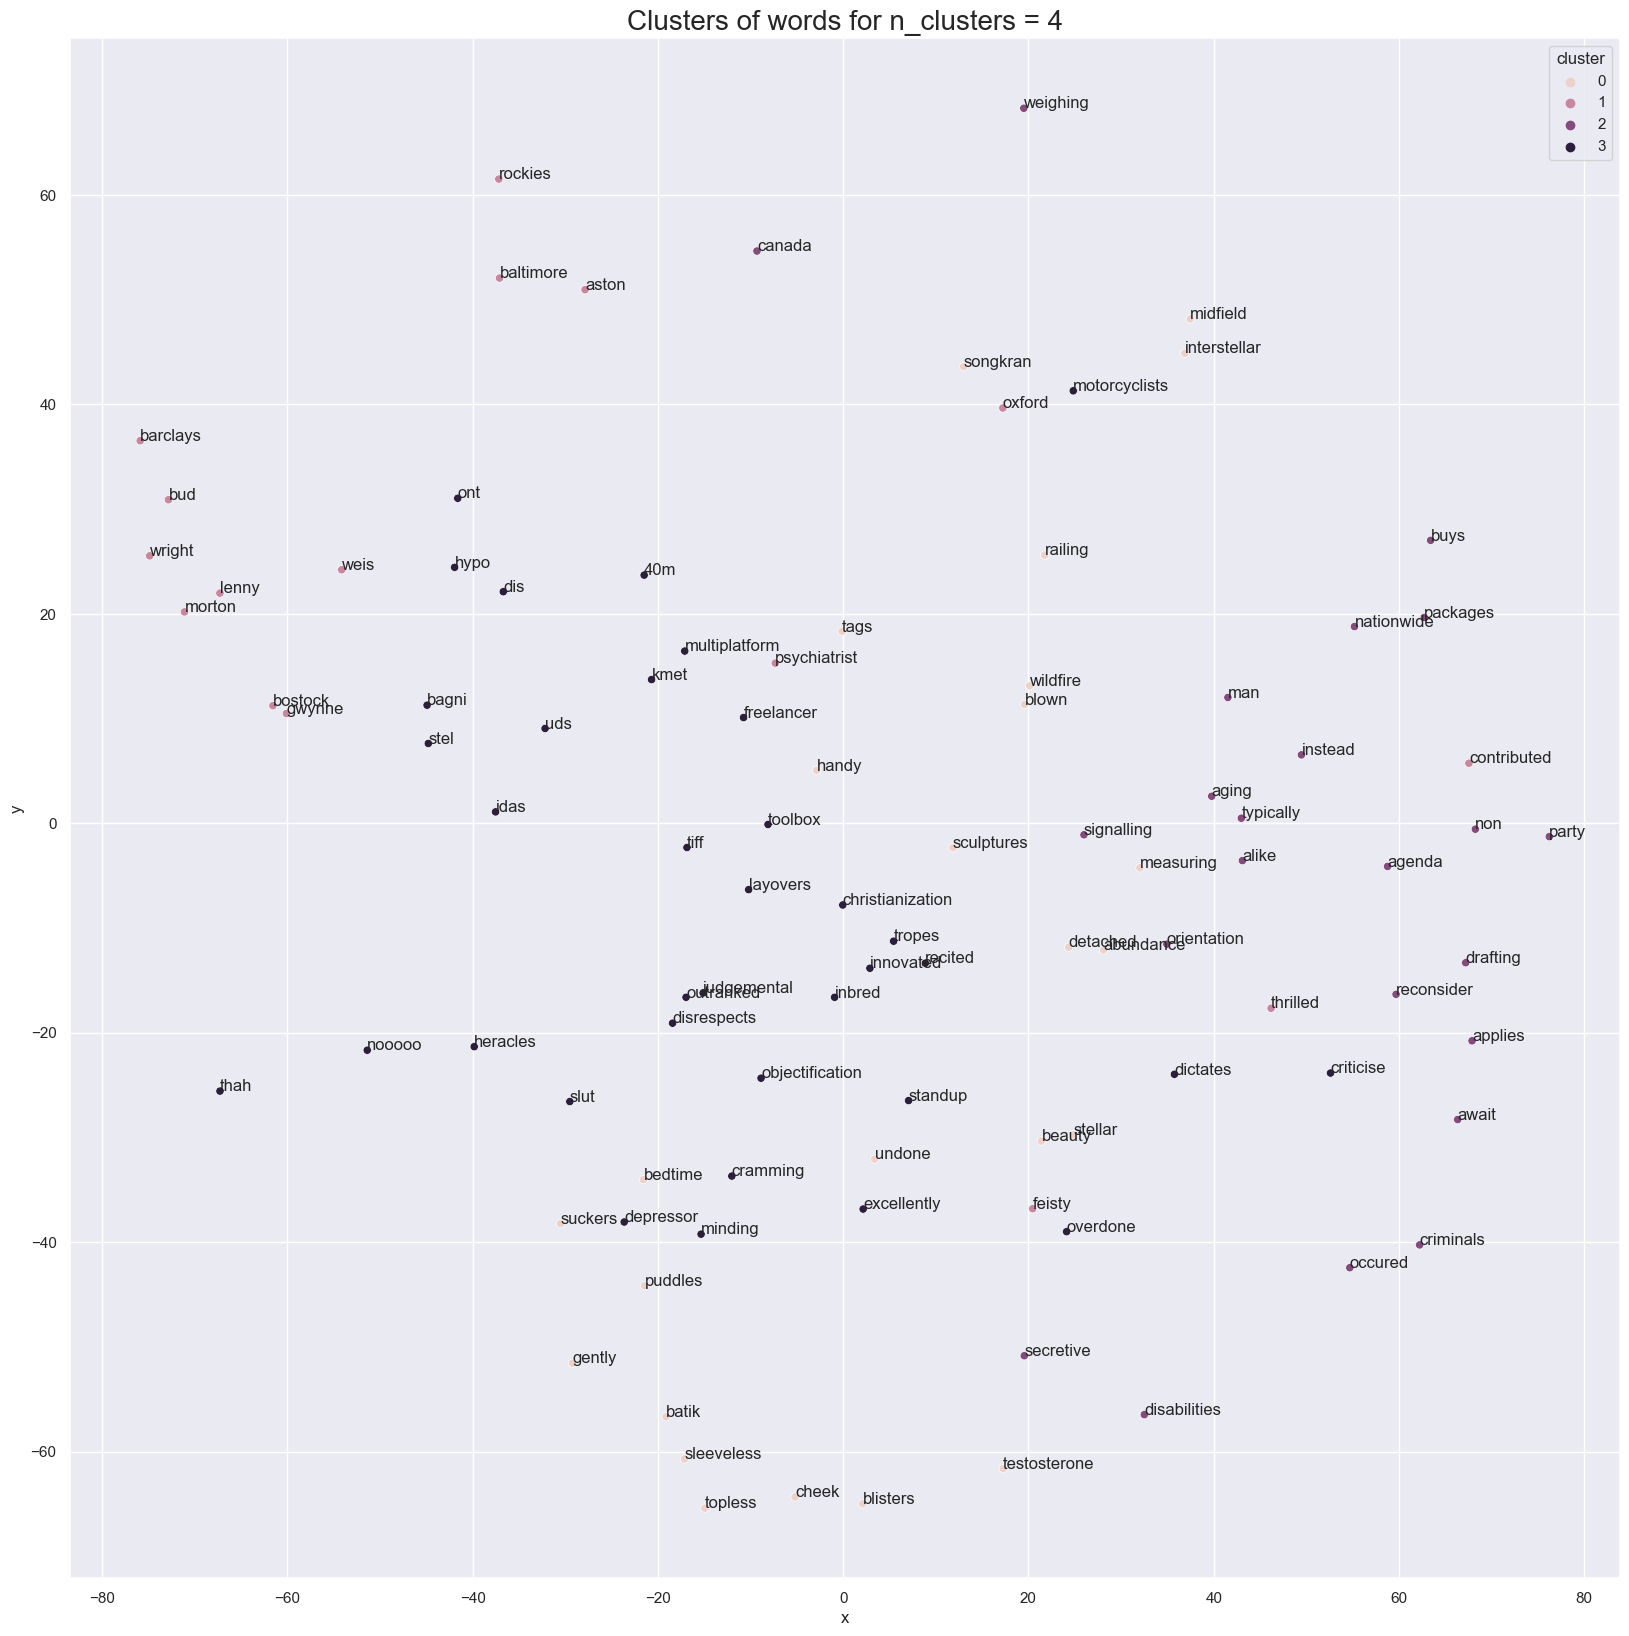

INFO: Assigning cluster to each word.


In [48]:
n_clusters = 4
n_samples = 100
dictionary = generate_dict(df)
vectorised_text = transform_text_to_vector(dictionary)

vectorised_text_output, vectors_2d, wcss = cluster_vectors(vectorised_text, n_clusters=n_clusters, n_samples=n_samples)

In [49]:
word_clusters = pd.DataFrame(vectorised_text_output, index=["Cluster"]).T.reset_index().rename(columns={"index": "Word"})

In [51]:
for cluster in range(n_clusters):
    # print(f"Cluster {cluster}")
    display(word_clusters[word_clusters["Cluster"] == cluster].head(20))
    # print("=================================================================================================")


Word  Cluster
3    recycling        0
30    navigate        0
53     combine        0
114       room        0
133    amazing        0
152      smile        0
153  literally        0
179     styles        0
191     insert        0
198       foot        0
217    stalked        0
233      sleep        0
239     nerves        0
246   simulate        0
262   relaxing        0
268     breads        0
287       tips        0
299     jargon        0
319      click        0
329     twitch        0

Word  Cluster
9              hi        1
15        analyst        1
31            hey        1
60       engineer        1
98            min        1
107    supervisor        1
111  receptionist        1
112    assistants        1
118           aka        1
121          lady        1
122       manager        1
172         mates        1
240   interviewer        1
247         coach        1
336         hello        1
360            im        1
426     graduated        1
631         hired        1
632     scientist        1
639    associates        1

Word  Cluster
0        design        2
1        refuse        2
2    collection        2
4         sites        2
5          hear        2
6          huge        2
7        demand        2
8      nowadays        2
10    economics        2
11     graduate        2
12        years        2
13   experience        2
14         risk        2
16      looking        2
17         make        2
18       career        2
19        shift        2
20       people        2
21    community        2
22  development        2

Word  Cluster
26          mentors        3
36      informatics        3
42   bioinformatics        3
70            maths        3
72              etc        3
110              ie        3
162         rapport        3
212             fid        3
218        linkedin        3
250              qa        3
255            dont        3
256          overdo        3
272              gl        3
279            isnt        3
300     freelancing        3
301      monetizing        3
308    kickstarting        3
316           youre        3
337             ive        3
354            mods        3